In [1]:
from bs4 import BeautifulSoup
import re
import random
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error
import  time, copy

In [2]:
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup
import re
import io

def extract_all_itavi_data_final(root_dir):
    """
    Lit tous les fichiers, extrait les infos (table 0) et les données (table 2).
    Crée les variables globales 'df_Lot_X' et 'info_Lot_X' en utilisant la logique de nommage originale.
    """
    root = Path(root_dir)
    xls_files = [f for f in root.glob("*.xls") if f.is_file()]
    
    print("--- Début de la lecture et de la création des DataFrames ---")
    
    nombre_lots_crees = 0

    for file_path in xls_files:
        file_name = file_path.name.lower()
        
        if not (file_name.startswith("lot") or file_name.startswith("synthese")):
            continue

        try:
            with open(file_path, "r", encoding="latin1") as f:
                html_content = f.read()
            tables = pd.read_html(io.StringIO(html_content))

            if len(tables) < 3:
                print(f"[!] Moins de 3 tables dans {file_path.name}, fichier ignoré.")
                continue
            
            # --- EXTRACTION DES DEUX TABLES ---
            df_info = tables[0]
            df_data = tables[2]
            
        except Exception as e:
            print(f"[ERREUR] Impossible de traiter {file_path.name} : {e}")
            continue
        
        # Nettoyage des MultiIndex pour les deux DataFrames
        for df in [df_info, df_data]:
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = [
                    col[0] if col[0] == col[1] or pd.isna(col[1]) or col[1] == '' else f"{col[0]}_{col[1]}"
                    for col in df.columns
                ]
            df.reset_index(drop=True, inplace=True)

        # --- CONSERVATION DE VOTRE LOGIQUE DE NOMMAGE ORIGINALE ET ROBUSTE ---
        base_name = file_path.stem
        match = re.match(r"(lot|synthese)\s*([a-zA-Z0-9\-\s\.]+)", base_name, re.IGNORECASE)
        
        if match:
            identifier = match.group(2).strip()
            clean_identifier = re.sub(r'[^a-zA-Z0-9]+', '_', identifier)
            var_name_base = f"df_Lot_{clean_identifier}"
        else:
            clean_base_name = re.sub(r'[^a-zA-Z0-9]+', '_', base_name)
            var_name_base = f"df_Lot_{clean_base_name}"

        # Application de vos règles de nettoyage de nom
        var_name_base = var_name_base.replace('df_Lot__', 'df_Lot_').replace('synthese_', '')
        parts = var_name_base.split('_')
        if len(parts) > 2 and (parts[1].lower() == 'lot'):
            var_name_base = f"df_Lot_{'_'.join(parts[2:])}"
        if var_name_base.endswith('_'):
            var_name_base = var_name_base[:-1]

        # On a maintenant une base propre comme 'df_Lot_44'
        
        # On crée les deux variables globales
        globals()[var_name_base] = df_data
        globals()[var_name_base.replace('df_', 'info_')] = df_info
        
        print(f"✅ Variables créées : {var_name_base} et {var_name_base.replace('df_', 'info_')}")
        nombre_lots_crees += 1

    print(f"\n--- Fin de la lecture. {nombre_lots_crees} lots ont été chargés. ---")


# --- APPEL DE LA FONCTION DE LECTURE ---
extract_all_itavi_data_final("C:\\Users\\benam\\Downloads\\Ancien Download\\inr_normallisé\\kaggle\\input\\itavi-dataset")

--- Début de la lecture et de la création des DataFrames ---
✅ Variables créées : df_Lot_1 et info_Lot_1
✅ Variables créées : df_Lot_2 et info_Lot_2
✅ Variables créées : df_Lot_23 et info_Lot_23
✅ Variables créées : df_Lot_24 et info_Lot_24
✅ Variables créées : df_Lot_25 et info_Lot_25
✅ Variables créées : df_Lot_26 et info_Lot_26
✅ Variables créées : df_Lot_27 et info_Lot_27
✅ Variables créées : df_Lot_28 et info_Lot_28
✅ Variables créées : df_Lot_29 et info_Lot_29
✅ Variables créées : df_Lot_3 et info_Lot_3
✅ Variables créées : df_Lot_30 et info_Lot_30
✅ Variables créées : df_Lot_31 et info_Lot_31
✅ Variables créées : df_Lot_32 et info_Lot_32
✅ Variables créées : df_Lot_33 et info_Lot_33
✅ Variables créées : df_Lot_34 et info_Lot_34
✅ Variables créées : df_Lot_37 et info_Lot_37
✅ Variables créées : df_Lot_38 et info_Lot_38
✅ Variables créées : df_Lot_39 et info_Lot_39
✅ Variables créées : df_Lot_4 et info_Lot_4
✅ Variables créées : df_Lot_40 et info_Lot_40
✅ Variables créées : df_Lot

In [3]:
import re
import unicodedata


ALIAS2CANON = {
   
    "Date": "date",
    "Age":  "age",


    "Mixtes_Nombres":   "mixtes_nombres",
    "Mixtes_Morts":     "mixtes_morts",
    "Mixtes_Eliminés":  "mixtes_elimines",
    "Mixtes_Cardiaques":"mixtes_cardiaques",
    "Mixtes_Sortis":    "mixtes_sortis",
    "Mixtes_Poids":     "mixtes_poids",
    "Mixtes_GMQ":       "mixtes_gmq",
    "Mixtes":           "mixtes_gmq",   

    "Aliment_Kg":       "aliment_kg",
    "CHAINES_Kg":       "aliment_kg",
    "chaines_Kg":       "aliment_kg",
    "chaine_Kg":        "aliment_kg",
    "chaine_kg":        "aliment_kg",
    "Chaine 2_Kg":      "aliment_kg",
    "chaine_2_kg":      "aliment_kg",
    "chaines cotés_Kg": "aliment_kg",
    "chaine milieu_Kg": "aliment_kg",
    "CHAINE EXTERIEUR_Kg": "aliment_kg",
    "CHAINE INTERIEUR_Kg": "aliment_kg",


    "Eau_L":            "eau_l",
    "eau_L":            "eau_l",
    "Eau":              "eau_l",
    "EAU 1_L":          "eau_l",
    "Eau 1_L":          "eau_l",
    "EAU N°1_L":        "eau_l",
    "Eau N°1_L":        "eau_l",
    "eau_1_l":          "eau_l",
    "eau_n_1_l":        "eau_l",
    "eau_1":            "eau_l",
    "eau_n_1":          "eau_l",

    "BRUME_L":          "brume_l",
    "Brume_L":          "brume_l",
    "brume_L":          "brume_l",
    "BRUME":            "brume_l",
    "BRUMISATION_L":    "brume_l",
    "Brumisation_L":    "brume_l",

    "LAVAGE_L":         "lavage_l",
    "lavage_L":         "lavage_l",
    "LAVAGE":           "lavage_l",

    "Vidange_L":        "vidange_l",
    "Vidange":          "vidange_l",


    "Temp_Mini":        "temp_mini",
    "Temp_Maxi":        "temp_maxi",
    "Temp":             "temp_mini",

    "Temp Ext_Mini":    "temp_ext_mini",
    "temp_ext":         "temp_ext_mini",
    "Temp Ext_Maxi":    "temp_ext_maxi",

    "Hygro_Mini":       "hygro_mini",
    "Hygro_Maxi":       "hygro_maxi",
    "Hygro":            "hygro_mini",

    "Hygro Ext_Mini":   "hygro_ext_mini",
    "Hygro Ext_Maxi":   "hygro_ext_maxi",


    "Air_m3/h":         "air_m3_h",
    "air":              "air_m3_h",

    "Gaz_M3":           "gaz_m3",
    "gaz_M3":           "gaz_m3",
    "Gaz":              "gaz_m3",
    "Gaz_Kg":           "gaz_kg",

    "Energie_Kw":       "energie_kw",
    "electricité_Kw":   "energie_kw",
    "électricité_Kw":   "energie_kw",
    "electricite":      "energie_kw",
    "energie":          "energie_kw",


    "VIS_Kg":           "vis_kg",
    "vis_Kg":           "vis_kg",
    "vis":              "vis_kg",

    "silo 1_Kg":        "silo_1_kg",
    "silo 2_Kg":        "silo_2_kg",
    "silo 3_Kg":        "silo_3_kg",
    "silo 1":           "silo_1_kg",
    "silo 2":           "silo_2_kg",
    "silo 3":           "silo_3_kg",
}


def normalize(col: str) -> str:
   
    col = ''.join(
        c for c in unicodedata.normalize('NFD', str(col))
        if unicodedata.category(c) != 'Mn'
    )
    col = col.lower()
    col = re.sub(r'[^a-z0-9]+', '_', col)
    col = re.sub(r'_+', '_', col).strip('_')
    return col

def canonize_df(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = []
    for c in df.columns:
        
        if str(c) in ALIAS2CANON:
            new_cols.append(ALIAS2CANON[str(c)])
            continue
        
        norm = normalize(c)
        if norm in ALIAS2CANON:
            new_cols.append(ALIAS2CANON[norm])
        else:
            
            new_cols.append(norm)
    out = df.copy()
    out.columns = new_cols
    return out


for var in [v for v in globals() if v.startswith("df_Lot_")]:
    globals()[var] = canonize_df(globals()[var])
    print(f"✅ Colonnes harmonisées pour {var}")


✅ Colonnes harmonisées pour df_Lot_1
✅ Colonnes harmonisées pour df_Lot_2
✅ Colonnes harmonisées pour df_Lot_23
✅ Colonnes harmonisées pour df_Lot_24
✅ Colonnes harmonisées pour df_Lot_25
✅ Colonnes harmonisées pour df_Lot_26
✅ Colonnes harmonisées pour df_Lot_27
✅ Colonnes harmonisées pour df_Lot_28
✅ Colonnes harmonisées pour df_Lot_29
✅ Colonnes harmonisées pour df_Lot_3
✅ Colonnes harmonisées pour df_Lot_30
✅ Colonnes harmonisées pour df_Lot_31
✅ Colonnes harmonisées pour df_Lot_32
✅ Colonnes harmonisées pour df_Lot_33
✅ Colonnes harmonisées pour df_Lot_34
✅ Colonnes harmonisées pour df_Lot_37
✅ Colonnes harmonisées pour df_Lot_38
✅ Colonnes harmonisées pour df_Lot_39
✅ Colonnes harmonisées pour df_Lot_4
✅ Colonnes harmonisées pour df_Lot_40
✅ Colonnes harmonisées pour df_Lot_41
✅ Colonnes harmonisées pour df_Lot_42
✅ Colonnes harmonisées pour df_Lot_43
✅ Colonnes harmonisées pour df_Lot_44
✅ Colonnes harmonisées pour df_Lot_45
✅ Colonnes harmonisées pour df_Lot_46
✅ Colonnes harmo

In [4]:
def _clean_series(ser: pd.Series) -> pd.Series:
    """
    VERSION AMÉLIORÉE : Gère les artéfacts HTML comme ' '.
    """
    # On s'assure que c'est bien une chaîne de caractères pour utiliser .str
    ser = ser.astype(str)
    
    # On applique les remplacements
    ser = (
        ser.str.replace(",", ".", regex=False)
           .str.replace("--", "", regex=False)
           # --- NOUVELLE RÈGLE ---
           # On supprime tout ce qui n'est PAS un chiffre, un point ou un tiret
           .str.replace(r"[^\d\.\-]", "", regex=True)
           # On s'assure qu'il n'y a qu'un seul point décimal
           .str.replace(r"\.(?=.*\.)", "", regex=True) 
    )
    
    # On convertit en numérique à la fin
    return pd.to_numeric(ser, errors="coerce")
    
def _rename_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Parcourt les colonnes du DataFrame. Si des noms sont dupliqués,
    elle les renomme en ajoutant un suffixe (ex: 'col', 'col_1', 'col_2').
    """
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup if i == 0 else f"{dup}_{i}" for i, c in enumerate(cols[cols == dup])
        ]
    df.columns = cols
    return df

In [5]:
import pandas as pd
import numpy as np

# ===================================================================
# CELLULE FINALE DE PRÉPARATION DES DONNÉES (AVEC DOUBLE FILTRAGE)
# ===================================================================

# --- 1. Définition des Seuils ---
SEUIL_MIN_JOURS = 30
SEUIL_MAX_JOURS = 55
LONGUEUR_SEQUENCE_FIXE = 46 # Assez grand pour contenir tous les âges jusqu'à 45

print("--- Début de la préparation des données pour les lots 'standards' ---")
print(f"Critères : Nombre de jours de données >= {SEUIL_MIN_JOURS} ET Âge maximum <= {SEUIL_MAX_JOURS}")

# --- 2. Audit et Filtrage en une seule passe ---
lots_valides = []
donnees_lots_valides = []

for var in [v for v in globals() if v.startswith("df_Lot_")]:
    lot_name = var.replace("df_", "")
    df_lot_brut = globals()[var]
    df = df_lot_brut.copy()

    df = _rename_duplicate_columns(df)

    # Nettoyage de base (identique à l'audit)
    df = canonize_df(df)
    if 'age' not in df.columns: continue
    df['age'] = _clean_series(df['age'])
    df.dropna(subset=['age'], inplace=True)
    if df.empty: continue
    df['age'] = df['age'].astype(int)
    df = df[df['age'] >= 0]
    if df.empty: continue

    # Application des filtres
    nb_jours_valides = len(df)
    age_max = df['age'].max()

    if SEUIL_MIN_JOURS <= nb_jours_valides and age_max <= SEUIL_MAX_JOURS:
        lots_valides.append(lot_name)
        df['Lot_ID'] = lot_name # On ajoute l'ID pour la suite
        donnees_lots_valides.append(df)
    else:
        print(f"INFO : Lot '{lot_name}' écarté (Jours: {nb_jours_valides}, Âge max: {age_max})")

print(f"\n{len(lots_valides)} lots ont été conservés pour l'entraînement et le test.")

# --- 3. Création du X_all final ---
if donnees_lots_valides:
    X_all = pd.concat(donnees_lots_valides, ignore_index=True)
    print(f"DataFrame 'X_all' final créé avec la shape : {X_all.shape}")
else:
    raise ValueError("Aucun lot ne correspond aux critères de filtrage. Impossible de continuer.")
    
# --- 4. Création de la matrice de poids BRUTS avec PADDING ---
def creer_matrice_paddee(df_source, liste_lots, longueur_fixe):
    # ... (cette fonction est bonne, on la garde)
    id_col='Lot_ID'; time_col='age'; value_col='mixtes_poids'
    n_lots = len(liste_lots)
    matrice_brute = np.full((n_lots, longueur_fixe, 1), np.nan)
    for idx, lot_id in enumerate(liste_lots):
        group = df_source[df_source[id_col] == lot_id]
        if group.empty: continue
        jours = group[time_col].values; poids = _clean_series(group[value_col]).values
        # On s'assure que les jours sont dans les limites
        mask = jours < longueur_fixe
        matrice_brute[idx, jours[mask], 0] = poids[mask]
        s = pd.Series(matrice_brute[idx, :, 0])
        s.ffill(inplace=True); s.bfill(inplace=True)
        matrice_brute[idx, :, 0] = s.values
    return matrice_brute

matrice_poids_bruts_paddee = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=lots_valides,
    longueur_fixe=LONGUEUR_SEQUENCE_FIXE
)

# --- 5. Normalisation Globale (sur les lots courts uniquement) ---
mean_global = np.nanmean(matrice_poids_bruts_paddee)
std_global = np.nanstd(matrice_poids_bruts_paddee)
scaler_global = {'mean': mean_global, 'std': std_global}

donnees_normalisees = (matrice_poids_bruts_paddee - mean_global) / std_global

print("\n--- Données des lots 'standards' préparées et normalisées ---")
print(f"Shape de la matrice normalisée finale : {donnees_normalisees.shape}")
print(f"Scaler global : Mean={mean_global:.2f}, Std={std_global:.2f}")

--- Début de la préparation des données pour les lots 'standards' ---
Critères : Nombre de jours de données >= 30 ET Âge maximum <= 55
INFO : Lot 'Lot_23' écarté (Jours: 14, Âge max: 13)
INFO : Lot 'Lot_58' écarté (Jours: 86, Âge max: 85)
INFO : Lot 'Lot_59_Rennes_LP_2024' écarté (Jours: 88, Âge max: 87)
INFO : Lot 'Lot_59' écarté (Jours: 88, Âge max: 87)
INFO : Lot 'Lot_61' écarté (Jours: 88, Âge max: 87)
INFO : Lot 'Lot_12' écarté (Jours: 22, Âge max: 21)
INFO : Lot 'Lot_68' écarté (Jours: 109, Âge max: 108)
INFO : Lot 'Lot_70' écarté (Jours: 109, Âge max: 108)
INFO : Lot 'Lot_C' écarté (Jours: 86, Âge max: 85)

48 lots ont été conservés pour l'entraînement et le test.
DataFrame 'X_all' final créé avec la shape : (1862, 28)

--- Données des lots 'standards' préparées et normalisées ---
Shape de la matrice normalisée finale : (48, 46, 1)
Scaler global : Mean=1073.65, Std=773.68


In [6]:
# --- On garde vos fonctions de nettoyage du début ---
# ... (canonize_df, _rename_duplicate_columns, _clean_series)

# --- NOUVELLE FONCTION DE PRÉPARATION, VERSION "SÛRE" ---

def prepare_data_for_timeflow_safe(df: pd.DataFrame, lot_name: str):
    """
    Cette fonction préserve l'intégrité de la série temporelle.
    Elle ne supprime QUE les lignes où l'âge est manquant ou négatif.
    """
    if df.empty:
        return pd.DataFrame()

    # 1. Copie et renommage des colonnes dupliquées (bonne pratique)
    df = df.copy()
    df = _rename_duplicate_columns(df)

    # 2. On s'assure que les colonnes essentielles existent
    if 'age' not in df.columns or 'mixtes_poids' not in df.columns:
        print(f"AVERTISSEMENT [{lot_name}]: Colonnes 'age' ou 'mixtes_poids' manquantes. Lot ignoré.")
        return pd.DataFrame()

    # 3. Nettoyage CIBLÉ des colonnes, sans appliquer de filtres globaux
    df['age'] = _clean_series(df['age'])
    df['mixtes_poids'] = _clean_series(df['mixtes_poids'])

    # 4. GESTION DES PROBLÈMES DE DONNÉES (la partie la plus importante)
    
    # a) Supprimer les lignes où l'âge est complètement manquant après nettoyage
    df.dropna(subset=['age'], inplace=True)
    if df.empty:
        print(f"AVERTISSEMENT [{lot_name}]: Aucune ligne avec un âge valide. Lot ignoré.")
        return pd.DataFrame()
        
    # b) S'assurer que 'age' est un entier
    df['age'] = df['age'].astype(int)
    
    # c) Supprimer les âges négatifs (cas du Lot 30)
    df = df[df['age'] >= 0]
    if df.empty:
        print(f"AVERTISSEMENT [{lot_name}]: Aucune ligne avec un âge positif ou nul. Lot ignoré.")
        return pd.DataFrame()

    # 5. Sélection et tri final
    
    # On garde les colonnes essentielles
    df_final = df[['age', 'mixtes_poids']].copy()
    
    # On supprime les jours dupliqués en gardant la PREMIÈRE occurrence.
    # Cela résout les problèmes de "valeurs au milieu non prises".
    df_final = df_final.drop_duplicates(subset=['age'], keep='first')
    
    # On trie par âge pour garantir l'ordre chronologique.
    # Cela résout les problèmes de "non ordonné".
    df_final = df_final.sort_values(by='age').reset_index(drop=True)

    return df_final

# --- NOUVELLE BOUCLE DE CRÉATION DE X_all (inchangée mais cruciale) ---

# ... (votre code qui définit les df_Lot_... est ici)

# On canonise les colonnes une seule fois au début
for var in [v for v in globals() if v.startswith("df_Lot_")]:
    globals()[var] = canonize_df(globals()[var])

X_all_list = []
for lot_name, df_lot in zip(lots_valides, donnees_lots_valides):
    #lot_name = var.replace("df_", "")
    #df_lot = globals()[var]
    
    # On appelle notre nouvelle fonction "sûre"
    df_lot_prepare = prepare_data_for_timeflow_safe(df_lot, lot_name)

    if df_lot_prepare.empty:
        continue

    df_lot_prepare["Lot_ID"] = lot_name
    X_all_list.append(df_lot_prepare)

if X_all_list:
    X_all = pd.concat(X_all_list, ignore_index=True)
    print("DataFrame X_all final créé.")
    print(X_all.info())
else:
    print("Aucun lot n'a pu être traité.")
    X_all = pd.DataFrame()

DataFrame X_all final créé.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1862 entries, 0 to 1861
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1862 non-null   int64  
 1   mixtes_poids  1862 non-null   float64
 2   Lot_ID        1862 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 43.8+ KB
None


In [7]:
import torch 

def position(position, features, layers, activation):
    """Use the position as input (i.e. no conditioning)
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """

    h = position

    for i, l in enumerate(layers):
        h = activation(l(h))

    return h


def feature(position, features, layers, activation):
    """Use the features as input.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """

    h = features

    for i, l in enumerate(layers):
        h = activation(l(h))

    return h


def concat(position, features, layers, activation):
    """Concatenates the input onto the features, and then feeds into the input of the neural network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """

    h = torch.cat([position, features], dim=-1)

    for i, l in enumerate(layers):
        h = activation(l(h))
    return h


def film_linear(position, features, layers, activation, with_batch=True):
    """Applies film conditioning (multiply only) on the network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """
    feature_shape = features.shape[0]
    feature_dim = features.shape[-1]
    num_hidden = len(layers)
    # Maybe add assertion here... but if it errors, your feature_dim size is wrong
    if with_batch:
        features = features.reshape(feature_shape, 1, num_hidden, feature_dim // num_hidden)
    else:
        features = features.reshape(feature_shape, num_hidden, feature_dim // num_hidden)

    h = position

    for i, l in enumerate(layers):
        # Maybe also add another assertion here
        h = activation(l(h) * features[..., i, :])
    return h


def film_translate(position, features, layers, activation, with_batch=True):
    """Applies film conditioning (add only) on the network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """
    feature_shape = features.shape[0]  # features.shape[:-1]
    feature_dim = features.shape[-1]
    num_hidden = len(layers)
    # Maybe add assertion here... but if it errors, your feature_dim size is wrong

    if with_batch:
        features = features.reshape(feature_shape, 1, num_hidden, feature_dim // num_hidden)
    else:
        features = features.reshape(feature_shape, num_hidden, feature_dim // num_hidden)

    h = position

    for i, l in enumerate(layers):
        # Maybe also add another assertion here
        h = activation(l(h) + features[..., i, :])
    return h


def film(position, features, layers, activation, with_batch=True):
    """Applies film conditioning (add only) on the network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """
    feature_shape = features.shape[0]
    feature_dim = features.shape[-1]
    num_hidden = len(layers)
    # Maybe add assertion here... but if it errors, your feature_dim size is wrong
    
    if with_batch:
        features = features.reshape(
        feature_shape, 1, 2, num_hidden, feature_dim // (num_hidden * 2)
    )
    else:

        features = features.reshape(
            feature_shape, 2, num_hidden, feature_dim // (num_hidden * 2)
        )

    h = position

    for i, l in enumerate(layers):
        # Maybe also add another assertion here
        h = activation(l(h) * features[..., 0, i, :] + features[..., 1, i, :])
    return h

In [8]:
import numpy as np
import torch
import torch.nn as nn
from typing import Any, Dict



class LatentToModulation(nn.Module):
    """Maps a latent vector to a set of modulations.
    Args:
        latent_dim (int):
        num_modulations (int):
        dim_hidden (int):
        num_layers (int):
    """

    def __init__(
        self, latent_dim, num_modulations, dim_hidden, num_layers, activation=nn.SiLU
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_modulations = num_modulations
        self.dim_hidden = dim_hidden
        self.num_layers = num_layers
        self.activation = activation

        if num_layers == 1:
            self.net = nn.Linear(latent_dim, num_modulations)
        else:
            layers = [nn.Linear(latent_dim, dim_hidden), self.activation()]
            if num_layers > 2:
                for i in range(num_layers - 2):
                    layers += [nn.Linear(dim_hidden, dim_hidden), self.activation()]
            layers += [nn.Linear(dim_hidden, num_modulations)]
            self.net = nn.Sequential(*layers)

    def forward(self, latent):
        return self.net(latent)


class Bias(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(size), requires_grad=True)
        # Add latent_dim attribute for compatibility with LatentToModulation model
        self.latent_dim = size

    def forward(self, x):
        return x + self.bias


class OneHotProjector(nn.Module):
    def __init__(self, nb_series):
        super().__init__()
        self.projection =  nn.Linear(in_features=nb_series, 
                                        out_features=1, 
                                        bias=True)

    def forward(self, OneHot):
        return self.projection(OneHot)

class GaussianEncoding(nn.Module):
    def __init__(self, embedding_size, scale, dims=2, gaussian=True):
        super().__init__()
        self.embedding_size = embedding_size
        self.scale = scale

        if gaussian:
            bvals = torch.randn(embedding_size // 2, dims) * scale
        else:
            bvals = 2.0 ** torch.linspace(0, scale, embedding_size // 2) - 1

            if dims == 1:
                bvals = bvals[:, None]

            elif dims == 2:
                bvals = torch.stack([bvals, torch.zeros_like(bvals)], dim=-1)
                bvals = torch.cat([bvals, torch.roll(bvals, 1, -1)], dim=0)

            else:
                tmp = (dims - 1) * (torch.zeros_like(bvals),)
                bvals = torch.stack([bvals, *tmp], dim=-1)

                tmp = [torch.roll(bvals, i, -1) for i in range(1, dims)]
                bvals = torch.cat([bvals, *tmp], dim=0)

        avals = torch.ones((bvals.shape[0]))
        self.avals = nn.Parameter(avals, requires_grad=False)
        self.bvals = nn.Parameter(bvals, requires_grad=False)

    def forward(self, tensor) -> torch.Tensor:
        """
        Apply positional encoding to the input.
        """

        return torch.cat(
            [
                self.avals * torch.sin((2.0 * np.pi * tensor) @ self.bvals.T),
                self.avals * torch.cos((2.0 * np.pi * tensor) @ self.bvals.T),
            ],
            dim=-1,
        )


class NeRFEncoding(nn.Module):
    """PyTorch implementation of regular positional embedding, as used in the original NeRF and Transformer papers."""

    def __init__(
        self,
        num_freq,
        min_freq_log2,
        max_freq_log2,
        log_sampling=True,
        include_input=True,
        input_dim=3,
        base_freq=2,
    ):
        """Initialize the module.
        Args:
            num_freq (int): The number of frequency bands to sample.
            max_freq_log2 (int): The maximum frequency.
                                 The bands will be sampled at regular intervals in [0, 2^max_freq_log2].
            log_sampling (bool): If true, will sample frequency bands in log space.
            include_input (bool): If true, will concatenate the input.
            input_dim (int): The dimension of the input coordinate space.
        Returns:
            (void): Initializes the encoding.
        """
        super().__init__()

        self.num_freq = num_freq
        self.max_freq_log2 = max_freq_log2
        self.log_sampling = log_sampling
        self.include_input = include_input
        self.out_dim = 0
        self.base_freq = base_freq

        if include_input:
            self.out_dim += input_dim

        if self.log_sampling:
            self.bands = self.base_freq ** torch.linspace(
                min_freq_log2, max_freq_log2, steps=num_freq
            )
        else:
            self.bands = self.base_freq * torch.arange(
                min_freq_log2, num_freq, 1
                )

        self.bands = self.bands.to(dtype=torch.float32)

        # The out_dim is really just input_dim + num_freq * input_dim * 2 (for sin and cos)
        self.out_dim += self.bands.shape[0] * input_dim * 2
        self.bands = nn.Parameter(self.bands).requires_grad_(False)

    def forward(self, coords, with_batch=True):
        """Embeds the coordinates.
        Args:
            coords (torch.FloatTensor): Coordinates of shape [N, input_dim]
        Returns:
            (torch.FloatTensor): Embeddings of shape [N, input_dim + out_dim] or [N, out_dim].
        """
        if with_batch:
            N = coords.shape[0]
            winded = (coords[...,None, :] * self.bands[None,None,:,None]).reshape(
                N, coords.shape[1], coords.shape[-1] * self.num_freq)
            encoded = torch.cat([torch.sin(winded), torch.cos(winded)], dim=-1)
            if self.include_input:
                encoded = torch.cat([coords, encoded], dim=-1)

        else:
            N = coords.shape[0]
            winded = (coords[:, None] * self.bands[None, :, None]).reshape(
                N, coords.shape[1] * self.num_freq
            )
            encoded = torch.cat([torch.sin(winded), torch.cos(winded)], dim=-1)
            if self.include_input:
                encoded = torch.cat([coords, encoded], dim=-1)
        return encoded

    def name(self) -> str:
        """A human readable name for the given wisp module."""
        return "Positional Encoding"

    def public_properties(self) -> Dict[str, Any]:
        """Wisp modules expose their public properties in a dictionary.
        The purpose of this method is to give an easy table of outwards facing attributes,
        for the purpose of logging, gui apps, etc.
        """
        return {
            "Output Dim": self.out_dim,
            "Num. Frequencies": self.num_freq,
            "Max Frequency": f"2^{self.max_freq_log2}",
            "Include Input": self.include_input,
        }


class ModulatedFourierFeatures(nn.Module):
    """WARNING: the code does not support non-graph inputs.
        It needs to be adapted for (batch, num_points, coordinates) format
        The FiLM Modulated Network with Fourier Embedding used for the experiments on Airfrans.
        The code relies on conditoning functions: film, film_linear and film_translate.
    Args:
        nn (_type_): _description_
    """

    def __init__(
        self,
        input_dim=2,
        output_dim=1,
        num_frequencies=8,
        latent_dim=128,
        width=256,
        depth=3,
        modulate_scale=False,
        modulate_shift=True,
        frequency_embedding="nerf",
        include_input=True,
        scale=5,
        log_sampling=False,
        min_frequencies=0,
        max_frequencies=32,
        base_frequency=1.25,
    ):
        super().__init__()
        self.frequency_embedding = frequency_embedding
        self.include_input = include_input
        if frequency_embedding == "nerf":
            self.embedding = NeRFEncoding(
                num_frequencies,
                min_frequencies,
                max_frequencies,
                log_sampling=log_sampling,
                include_input=include_input,
                input_dim=input_dim,
                base_freq=base_frequency,
            )
            self.in_channels = [self.embedding.out_dim] + [width] * (depth - 1)

        elif frequency_embedding == "gaussian":
            self.scale = scale
            self.embedding = GaussianEncoding(
                embedding_size=num_frequencies * 2, scale=scale, dims=input_dim
            )
            embed_dim = (
                num_frequencies * 2 + input_dim
                if include_input
                else num_frequencies * 2
            )
            self.in_channels = [embed_dim] + [width] * (depth - 1)

        self.out_channels = [width] * (depth - 1) + [output_dim]
        self.latent_dim = latent_dim
        self.layers = nn.ModuleList(
            [nn.Linear(self.in_channels[k], self.out_channels[k]) for k in range(depth)]
        )
        self.depth = depth
        self.hidden_dim = width

        self.num_modulations = self.hidden_dim * (self.depth - 1)
        if modulate_scale and modulate_shift:
            # If we modulate both scale and shift, we have twice the number of
            # modulations at every layer and feature
            self.num_modulations *= 2
        self.latent_to_modulation = LatentToModulation(
            self.latent_dim, self.num_modulations, dim_hidden=256, num_layers=1
        )

        if modulate_shift and modulate_scale:
            self.conditioning = film
        elif modulate_scale and not modulate_shift:
            self.conditioning = film_linear
        else:
            self.conditioning = film_translate

    def modulated_forward(self, x, z):
        features = self.latent_to_modulation(z)
        #print('features', features)
        position = self.embedding(x)
        #print('positions', position)
        if self.frequency_embedding == "gaussian" and self.include_input:
            position = torch.cat([position, x], axis=-1)
        pre_out = self.conditioning(position, features, self.layers[:-1], torch.relu)
        out = self.layers[-1](pre_out)
        return out

In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset
import sys
from pathlib import Path


def set_requires_grad(module, tf=False):
    module.requires_grad = tf
    for param in module.parameters():
        param.requires_grad = tf


def set_seed(seed=33):
    """Set all seeds for the experiments.
    Args:
        seed (int, optional): seed for pseudo-random generated numbers.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)


class DatasetSamples(Dataset):
    """Custom dataset for encoding task. Contains the values, the codes, and the coordinates."""

    def __init__(self, v, grid, latent_dim, sample_ratio_batch=None):
        """
        Args:
            v (torch.Tensor): Dataset values, either x or y
            grid (torch.Tensor): Coordinates
            latent_dim (int, optional): Latent dimension of the code. Defaults to 256.
            with_time (bool, optional): If True, time dimension should be flattened into batch dimension. Defaults to False.
        """
        self.v = v
        self.z = torch.zeros((v.shape[0], latent_dim))
        self.c = grid

        if sample_ratio_batch == None:
            self.n_points = None
        else:
            self.n_points = int(sample_ratio_batch * self.c.shape[1])

    def __len__(self):
        return len(self.v)

    def __getitem__(self, idx, full_length=False):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.n_points == None or full_length == True:    
            sample_v = self.v[idx, ...]
            sample_z = self.z[idx, ...]
            sample_c = self.c[idx, ...]
        
        else:
            permutation = torch.randperm(self.c.shape[1])[:self.n_points]
            sample_v = self.v[idx, permutation, ...]
            sample_z = self.z[idx, ...]
            sample_c = self.c[idx, permutation, ...]


        return sample_v, sample_z, sample_c, idx

    def __setitem__(self, z_values, idx):
        # z_values = torch.tensor(np.array(z_values.clone()))
        z_values = z_values.clone()
        self.z[idx, ...] = z_values



class DatasetSamplesForecasting(torch.utils.data.Dataset):
    """
    Copie fidèle du code original du GitHub, avec la correction pour notre cas d'usage.
    """
    def __init__(self, 
                v, 
                grid, 
                latent_dim, 
                look_back_window, 
                horizon, 
                length_of_interest, 
                passed_ratio=None,
                horizon_ratio=None):
        
        self.v = v
        self.c = grid
        # self.z est utilisé pour stocker les codes latents si on les met à jour,
        # mais dans notre cas, on part de zéros à chaque fois.
        self.z = torch.zeros((v.shape[0], latent_dim))
        
        self.window_size = int(horizon + look_back_window)
        self.length_of_interest = length_of_interest
        self.horizon = horizon
        self.look_back_window = look_back_window

        if passed_ratio is None:
            self.n_points_passed = look_back_window # Si ratio non fourni, on prend tous les points
        else:
            self.n_points_passed = int(passed_ratio * look_back_window)

        if horizon_ratio is None:
            self.n_points_horizon = horizon # Si ratio non fourni, on prend tous les points
        else:
            self.n_points_horizon = int(horizon_ratio * horizon)

    def __len__(self):
        return len(self.v)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # --- LA CORRECTION CLÉ POUR NOTRE CAS SPÉCIFIQUE ---
        # Si la taille de la fenêtre est la même ou plus grande que la longueur d'intérêt,
        # il n'y a pas de choix aléatoire à faire. On prend toute la série.
        if self.window_size >= self.length_of_interest:
            first_point = 0
            end_point = self.window_size
        else:
            # Sinon, on garde la logique originale pour des séries plus longues
            end_point = torch.randint(self.window_size, self.length_of_interest, (1,)).item()
            first_point = end_point - self.window_size
        
        # Le reste du code est maintenant aligné avec l'original
        sample_v = self.v[idx, first_point : end_point, :]
        sample_c = self.c[first_point : end_point, :] # La grille est la même pour tous les lots

        v_passed = sample_v[:self.look_back_window]
        v_horizon = sample_v[self.look_back_window:] # Corrigé : utilise look_back_window, pas -horizon
        
        c_passed = sample_c[:self.look_back_window]
        c_horizon = sample_c[self.look_back_window:]

        # Sous-échantillonnage aléatoire des points pour l'entraînement
        permutation_passed = torch.randperm(self.look_back_window)[:self.n_points_passed]
        permutation_horizon = torch.randperm(self.horizon)[:self.n_points_horizon]

        # Les vrais échantillons qui seront envoyés au modèle
        real_sample_v_passed = v_passed[permutation_passed, ...]
        real_sample_v_horizon = v_horizon[permutation_horizon, ...]
        
        real_sample_c_passed = c_passed[permutation_passed, ...]
        real_sample_c_horizon = c_horizon[permutation_horizon, ...]
        
        sample_z = self.z[idx, :]

        return real_sample_v_passed, real_sample_v_horizon, sample_z, real_sample_c_passed, real_sample_c_horizon, idx
        
    def __setitem__(self, z_values, idx):
        # z_values = torch.tensor(np.array(z_values.clone()))
        z_values = z_values.clone()
        self.z[idx, ...] = z_values




def fixed_subsampling_series_imputations(dataset_name, 
                                         draw_ratio, 
                                         version=0,
                                         setting='classic',
                                         train_or_test='train'):

    '''
    Description
        Draw subsampling for specific version

    Arguments
        @dataset_name : in {'Solar', 'Electricity', 'Traffic'}
        @draw ratio : in {0.05, 0.1, 0.2, 0.3, 0.5}
        @version in {0, 1, 2, 3, 4}
        @setting : classic, train_test

    Return
        @series
        @grid
    '''
    DIR = str(Path(__file__).parents[1]) + '/data/' + dataset_name + '/Imputation/'

    if setting == 'classic':

        RESULTS_DIR = DIR + 'Classic_framework/X_subsampling_version_' + str(version) 
        FILE_NAME =  RESULTS_DIR + '/small_X_' + str(draw_ratio) + '.pt'
        dico = torch.load(FILE_NAME, map_location=torch.device('cpu'))

        grid = dico['small_grid']
        series = dico['small_data']
        permutations = dico['permutations']


    elif setting == 'train_test':

        if train_or_test == 'train' or train_or_test == 'test':

            RESULTS_DIR = DIR + 'Train_test_framework/X_subsampling_version_' + str(version) 
            FILE_NAME =  RESULTS_DIR + '/small_X_' + train_or_test + '_' + str(draw_ratio) + '.pt'
            dico = torch.load(FILE_NAME, map_location=torch.device('cpu'))

            grid = dico['small_grid']
            series = dico['small_data']
            permutations = dico['permutations']

        else:
            'not supported value'

    else:
        print("not supported setting")

    return series, grid, permutations




def fixed_sampling_series_imputations(dataset_name,  
                                      version=0,
                                      setting='classic',
                                      train_or_test='train'):
    
    """
    Description
        Draw whole sequence for specific version
    """

    DIR = str(Path(__file__).parents[1]) + '/data/' + dataset_name + '/Imputation/'

    if setting == 'classic':

        RESULTS_DIR = DIR + 'Classic_framework/X_subsampling_version_' + str(version) 
        FILE_NAME =  RESULTS_DIR + '/X_complete.pt'
        dico = torch.load(FILE_NAME, map_location=torch.device('cpu'))
        grid = dico['grid']
        series = dico['data']

    else:
        print("not supported setting")


    return series, grid



def fixed_sampling_series_forecasting(dataset_name, 
                                      horizon, 
                                      version=0,
                                      setting='classic',
                                      train_or_test='train'):

    '''
    Description
        Draw forecast sample

    Arguments
        @dataset_name : in {'Electricity', 'Traffic'}
        @horizon : in {96, 192, 336, 720}
        @version in {0, 1, 2, 3, 4}
        @setting : classic, train_test

    Return
        @series
        @grid
    '''

    DIR = str(Path(__file__).parents[1]) + '/data/' + dataset_name + '/Forecasting/'

    if setting == 'classic':

        RESULTS_DIR = DIR + 'Classic_framework/X_forecasting_version_' + str(version) 
        FILE_NAME_PASSED =  RESULTS_DIR + '/X_passed_horizon_' + str(horizon) + '.pt'
        FILE_NAME_TARGET =  RESULTS_DIR + '/X_target_horizon_' + str(horizon) + '.pt'
        dico_passed = torch.load(FILE_NAME_PASSED, map_location=torch.device('cpu'))
        dico_target = torch.load(FILE_NAME_TARGET, map_location=torch.device('cpu'))

        grid = dico_passed['grid']
        series_passed = dico_passed['X_passed']
        series_target = dico_target['X_target']

    else:
        print("not supported setting")

    return series_passed, series_target, grid


def z_normalize(X):

    X_mean = X[:,:,0].mean(dim=1)
    X_std = X[:,:,0].std(dim=1)
    X_normalize = (X[:,:,0].transpose(1,0) - X_mean) / (X_std + 1e-7)

    return X_normalize.transpose(1,0).unsqueeze(-1)


def z_normalize_out(X):
    
    X_mean = X[:,:,0].mean(dim=1)
    X_std = X[:,:,0].std(dim=1)
    X_normalize = (X[:,:,0].transpose(1,0) - X_mean) / (X_std + 1e-7)

    return X_normalize.transpose(1,0).unsqueeze(-1), X_mean, X_std



def z_denormalize_out(X_norm, X_mean, X_std):

    X = X_norm[:,:,0].transpose(1,0) * (X_std + 1e-7) + X_mean 

    return X.transpose(1,0).unsqueeze(-1)



def z_normalize_other(X, X_mean, X_std):

    X_normalize = (X[:,:,0].transpose(1,0) - X_mean) / (X_std + 1e-7)

    return X_normalize.transpose(1,0).unsqueeze(-1)



def convert_error(sample_r, score_learned, total_score):
    partial_score = (total_score - sample_r * score_learned) * 1 / (1-sample_r)
    return partial_score

In [10]:
import torch
import torch.nn as nn

mse_fn = torch.nn.MSELoss()
per_element_mse_fn = torch.nn.MSELoss(reduction="none")
per_element_bce_fn = torch.nn.BCEWithLogitsLoss(reduction="none")

class FFT_loss_torch(nn.Module):
    def __init__(self, lambda_fft):
        super(FFT_loss_torch, self).__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        return per_element_mse_fn(x1, x2) + self.lambda_fft * torch.nn.L1Loss()(torch.fft.rfft(x1), torch.fft.rfft(x2))

def per_element_multi_scale_fn(
    model_output,
    gt,
    loss_name="mse",
    last_element=False,
):
    if loss_name == "mse":
        loss_fn = per_element_mse_fn
    elif loss_name == "bce":
        loss_fn = per_element_bce_fn

    N = gt.shape[0]
    gt = gt.reshape(N, -1)
    loss = [loss_fn(out.reshape(N, -1), gt) for out in model_output]

    loss = torch.stack(loss)

    return loss


def batch_multi_scale_fn(model_output, gt, loss_name="mse", use_resized=False):
    # if use_resized:
    #    loss = [(out - gt_img)**2 for out, gt_img in zip(model_output['model_out']['output'], gt['img'])]
    # else:
    per_element_multi_scale_mse = per_element_multi_scale_fn(
        model_output, gt, loss_name=loss_name
    )
    # Shape (batch_size,)
    return per_element_multi_scale_mse.view(gt.shape[0], -1).mean(dim=1)


def per_element_nll_fn(x, y):
    num_examples = x.size()[0]

    negative_log_likelihood = -(y * torch.log(x) + (1 - y) * torch.log(1 - x))

    return negative_log_likelihood


def per_element_rel_mse_fn(x, y, reduction=True):
    num_examples = x.size()[0]

    diff_norms = torch.norm(
        x.reshape(num_examples, -1) - y.reshape(num_examples, -1), 2, 1
    )
    y_norms = torch.norm(y.reshape(num_examples, -1), 2, 1)

    return diff_norms / y_norms


def batch_mse_rel_fn(x1, x2):
    """Computes MSE between two batches of signals while preserving the batch
    dimension (per batch element MSE).
    Args:
        x1 (torch.Tensor): Shape (batch_size, *).
        x2 (torch.Tensor): Shape (batch_size, *).
    Returns:
        MSE tensor of shape (batch_size,).
    """
    # Shape (batch_size, *)
    # per_element_mse = per_element_mse_fn(x1, x2)
    per_element_mse = per_element_rel_mse_fn(x1, x2)
    # Shape (batch_size,)
    return per_element_mse.view(x1.shape[0], -1).mean(dim=1)


def batch_mse_fn(x1, x2):
    """Computes MSE between two batches of signals while preserving the batch
    dimension (per batch element MSE).
    Args:
        x1 (torch.Tensor): Shape (batch_size, *).
        x2 (torch.Tensor): Shape (batch_size, *).
    Returns:
        MSE tensor of shape (batch_size,).
    """
    # Shape (batch_size, *)
    per_element_mse = per_element_mse_fn(x1, x2)
    # Shape (batch_size,)
    return per_element_mse.view(x1.shape[0], -1).mean(dim=1)

class Batch_fft_loss(nn.Module):
    def __init__(self, lambda_fft):
        super(Batch_fft_loss, self).__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        """Computes MSE between two batches of signals while preserving the batch
        dimension (per batch element MSE).
        Args:
            x1 (torch.Tensor): Shape (batch_size, *).
            x2 (torch.Tensor): Shape (batch_size, *).
        Returns:
            MSE tensor of shape (batch_size,).
        """
        per_element_fft = FFT_loss_torch(self.lambda_fft)(x1, x2)
        # Shape (batch_size,)
        return per_element_fft.view(x1.shape[0], -1).mean(dim=1)


def batch_nll_fn(x1, x2):
    per_element_nll = per_element_nll_fn(x1, x2)
    return per_element_nll.view(x1.shape[0], -1).mean(dim=1)


def mse2psnr(mse):
    """Computes PSNR from MSE, assuming the MSE was calculated between signals
    lying in [0, 1].
    Args:
        mse (torch.Tensor or float):
    """
    return -10.0 * torch.log10(mse)


def psnr_fn(x1, x2):
    """Computes PSNR between signals x1 and x2. Note that the values of x1 and
    x2 are assumed to lie in [0, 1].
    Args:
        x1 (torch.Tensor): Shape (*).
        x2 (torch.Tensor): Shape (*).
    """
    return mse2psnr(mse_fn(x1, x2))


# from fno


# loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h ** (self.d / self.p)) * torch.norm(
            x.view(num_examples, -1) - y.view(num_examples, -1), self.p, 1
        )

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(
            x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1
        )
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)

        return diff_norms / y_norms

    def __call__(self, x, y):
        return self.rel(x, y)


# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(
        self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True
    ):
        super(HsLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [
                1,
            ] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(
            x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1
        )
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)
        return diff_norms / y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = (
            torch.cat(
                (
                    torch.arange(start=0, end=nx // 2, step=1),
                    torch.arange(start=-nx // 2, end=0, step=1),
                ),
                0,
            )
            .reshape(nx, 1)
            .repeat(1, ny)
        )
        k_y = (
            torch.cat(
                (
                    torch.arange(start=0, end=ny // 2, step=1),
                    torch.arange(start=-ny // 2, end=0, step=1),
                ),
                0,
            )
            .reshape(1, ny)
            .repeat(nx, 1)
        )
        k_x = torch.abs(k_x).reshape(1, nx, ny, 1).to(x.device)
        k_y = torch.abs(k_y).reshape(1, nx, ny, 1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced == False:
            weight = 1
            if k >= 1:
                weight += a[0] ** 2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1] ** 2 * (k_x**4 + 2 * k_x**2 * k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x * weight, y * weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x * weight, y * weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(
                    k_x**4 + 2 * k_x**2 * k_y**2 + k_y**4
                )
                loss += self.rel(x * weight, y * weight)
            loss = loss / (k + 1)

        return loss

In [11]:
# ===================================================================
# CELLULE DU MODULE 'losses' - À PLACER AVANT LES FONCTIONS DU MODÈLE
# ===================================================================

import torch
import torch.nn as nn

# --- Création du conteneur qui simulera notre module 'losses' ---
class LossesContainer:
    pass

losses = LossesContainer()
print("Création du module simulé 'losses'...")

# --- On attache toutes les fonctions et classes à notre conteneur ---

losses.mse_fn = torch.nn.MSELoss()
losses.per_element_mse_fn = torch.nn.MSELoss(reduction="none")
losses.per_element_bce_fn = torch.nn.BCEWithLogitsLoss(reduction="none")

# Classe FFT_loss_torch
class _FFT_loss_torch(nn.Module):
    def __init__(self, lambda_fft):
        super().__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        # On utilise la fonction déjà attachée à notre conteneur
        return losses.per_element_mse_fn(x1, x2) + self.lambda_fft * torch.nn.L1Loss()(torch.fft.rfft(x1), torch.fft.rfft(x2))
losses.FFT_loss_torch = _FFT_loss_torch

# Fonction per_element_multi_scale_fn
def _per_element_multi_scale_fn(model_output, gt, loss_name="mse", last_element=False):
    if loss_name == "mse":
        loss_fn = losses.per_element_mse_fn
    elif loss_name == "bce":
        loss_fn = losses.per_element_bce_fn
    N = gt.shape[0]
    gt = gt.reshape(N, -1)
    loss = [loss_fn(out.reshape(N, -1), gt) for out in model_output]
    loss = torch.stack(loss)
    return loss
losses.per_element_multi_scale_fn = _per_element_multi_scale_fn

# Fonction batch_multi_scale_fn
def _batch_multi_scale_fn(model_output, gt, loss_name="mse", use_resized=False):
    per_element_multi_scale_mse = losses.per_element_multi_scale_fn(
        model_output, gt, loss_name=loss_name
    )
    return per_element_multi_scale_mse.view(gt.shape[0], -1).mean(dim=1)
losses.batch_multi_scale_fn = _batch_multi_scale_fn

# Fonction per_element_nll_fn
def _per_element_nll_fn(x, y):
    negative_log_likelihood = -(y * torch.log(x + 1e-8) + (1 - y) * torch.log(1 - x + 1e-8)) # Ajout d'epsilon pour la stabilité
    return negative_log_likelihood
losses.per_element_nll_fn = _per_element_nll_fn

# Fonction batch_mse_fn
def _batch_mse_fn(x1, x2):
    per_element_mse = losses.per_element_mse_fn(x1, x2)
    return per_element_mse.view(x1.shape[0], -1).mean(dim=1)
losses.batch_mse_fn = _batch_mse_fn

# Classe Batch_fft_loss
class _Batch_fft_loss(nn.Module):
    def __init__(self, lambda_fft):
        super().__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        per_element_fft = losses.FFT_loss_torch(self.lambda_fft)(x1, x2)
        return per_element_fft.view(x1.shape[0], -1).mean(dim=1)
losses.Batch_fft_loss = _Batch_fft_loss

# Fonction batch_nll_fn
def _batch_nll_fn(x1, x2):
    per_element_nll = losses.per_element_nll_fn(x1, x2)
    return per_element_nll.view(x1.shape[0], -1).mean(dim=1)
losses.batch_nll_fn = _batch_nll_fn

# Fonction mse2psnr
def _mse2psnr(mse):
    return -10.0 * torch.log10(mse + 1e-8) # Ajout d'epsilon
losses.mse2psnr = _mse2psnr

# Fonction psnr_fn
def _psnr_fn(x1, x2):
    return losses.mse2psnr(losses.mse_fn(x1, x2))
losses.psnr_fn = _psnr_fn

# Le reste du code (LpLoss, HsLoss) n'est pas utilisé par outer_step,
# mais on peut les ajouter de la même manière si nécessaire. Pour l'instant, on les omet pour la clarté.

print("Le module 'losses' a été entièrement simulé et est prêt à l'emploi.")

Création du module simulé 'losses'...
Le module 'losses' a été entièrement simulé et est prêt à l'emploi.


In [12]:
from functools import partial
import sys
from pathlib import Path



import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from torch import autograd
from torch.nn.parallel import DistributedDataParallel as DDP


def inner_loop(
    func_rep,
    modulations,
    coordinates,
    features,
    inner_steps,
    inner_lr,
    look_back_window_size,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    lambda_fft=0,
):
    """Performs inner loop, i.e. fits modulations such that the function
    representation can match the target features.

    Args:
        func_rep (models.ModulatedSiren):
        modulations (torch.Tensor): Shape (batch_size, latent_dim).
        coordinates (torch.Tensor): Coordinates at which function representation
            should be evaluated. Shape (batch_size, *, coordinate_dim).
        features (torch.Tensor): Target features for model to match. Shape
            (batch_size, *, feature_dim).
        inner_steps (int): Number of inner loop steps to take.
        inner_lr (float): Learning rate for inner loop.
        is_train (bool):
        gradient_checkpointing (bool): If True uses gradient checkpointing. This
            can massively reduce memory consumption.
    """
    fitted_modulations = modulations
    for step in range(inner_steps):
        if gradient_checkpointing:
            fitted_modulations = cp.checkpoint(
                inner_loop_step,
                func_rep,
                fitted_modulations,
                coordinates,
                features,
                torch.as_tensor(inner_lr),
                torch.as_tensor(is_train),
                torch.as_tensor(gradient_checkpointing),
                loss_type,
            )
        else:
            fitted_modulations = inner_loop_step(
                func_rep,
                fitted_modulations,
                coordinates,
                features,
                inner_lr,
                look_back_window_size,
                is_train,
                gradient_checkpointing,
                loss_type,
                lambda_fft,
            )
    return fitted_modulations


def inner_loop_step(
    func_rep,
    modulations,
    coordinates,
    features,
    inner_lr,
    look_back_window_size,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    lambda_fft=0,
):
    """Performs a single inner loop step."""
    detach = not torch.is_grad_enabled() and gradient_checkpointing
    batch_size = len(features)
    if loss_type == "mse":
        element_loss_fn = losses.per_element_mse_fn
    elif loss_type == "bce":
        element_loss_fn = losses.per_element_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        element_loss_fn = partial(
            losses.per_element_multi_scale_fn,
            loss_name=loss_name,
            last_element=False,
        )
    elif loss_type == 'fft':
        element_loss_fn = losses.Batch_fft_loss(lambda_fft)

    N, C = features.shape[0], features.shape[-1]

    with torch.enable_grad():
        # Note we multiply by batch size here to undo the averaging across batch
        # elements from the MSE function. Indeed, each set of modulations is fit
        # independently and the size of the gradient should not depend on how
        # many elements are in the batch
        features_recon = func_rep.modulated_forward(coordinates, modulations)
        loss = element_loss_fn(features_recon, features).mean() * batch_size

        # If we are training, we should create graph since we will need this to
        # compute second order gradients in the MAML outer loop
        grad = torch.autograd.grad(
            loss,
            modulations,
            create_graph=is_train and not detach,
        )[0]
        # if clip_grad_value is not None:
        #    nn.utils.clip_grad_value_(grad, clip_grad_value)
    # Perform single gradient descent step
    return modulations - inner_lr * grad


def outer_step(
    func_rep,
    coordinates_p,
    coordinates_h,
    features_p,
    features_h,
    inner_steps,
    inner_lr,
    look_back_window_size,
    horizon,
    w_passed,
    w_futur,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    lambda_fft=0,
    modulations=0,
):
    """

    Args:
        coordinates (torch.Tensor): Shape (batch_size, *, coordinate_dim). Note this
            _must_ have a batch dimension.
        features (torch.Tensor): Shape (batch_size, *, feature_dim). Note this _must_
            have a batch dimension.
    """

    if loss_type == "mse":
        loss_fn = losses.batch_mse_fn
    elif loss_type == "bce":
        loss_fn = losses.batch_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        loss_fn = partial(losses.batch_multi_scale_fn, loss_name=loss_name)
    elif loss_type == 'fft':
        loss_fn = losses.Batch_fft_loss(lambda_fft)

    func_rep.zero_grad()
    batch_size = len(coordinates_p)
    if isinstance(func_rep, DDP):
        func_rep = func_rep.module

    modulations = modulations.requires_grad_()

    feat_p = features_p.clone()
    coords_p = coordinates_p.clone()

    # Run inner loop

    modulations = inner_loop(
        func_rep,
        modulations,
        coords_p,
        feat_p,
        inner_steps,
        inner_lr,
        look_back_window_size,
        is_train,
        gradient_checkpointing,
        loss_type,
    )

    with torch.set_grad_enabled(is_train):
        features_recon_p = func_rep.modulated_forward(coordinates_p, modulations)
        features_recon_h = func_rep.modulated_forward(coordinates_h, modulations)

        per_example_loss = w_passed * loss_fn(features_recon_p, 
                                              features_p) + \
                           w_futur * loss_fn(features_recon_h, 
                                             features_h)

        loss = per_example_loss.mean()

    outputs = {
        "loss": loss,
        "psnr": losses.mse2psnr(per_example_loss).mean().item(),
        "modulations": modulations,
    }

    return outputs

In [13]:
from sklearn.model_selection import train_test_split
import re

# ===================================================================
# CELLULE DE CONFIGURATION (POUR MODÈLE SANS CONTEXTE)
# ===================================================================

# --- 1. Séparation des lots en Entraînement / Test ---

# --- CORRECTION : On utilise la variable 'lots_valides' de la cellule précédente ---
all_valid_lot_ids = lots_valides 

# On définit MANUELLEMENT les lots pour le jeu de test
test_lot_ids_manuels = ["Lot_45", "Lot_21", "Lot_5", "Lot_4", "Lot_40"]

# On vérifie que les lots demandés existent
test_lot_ids = [lot for lot in test_lot_ids_manuels if lot in all_valid_lot_ids]
if len(test_lot_ids) != len(test_lot_ids_manuels):
    print("AVERTISSEMENT : Certains lots demandés pour le test n'ont pas été trouvés dans les données valides.")

# Le jeu d'entraînement est simplement TOUS les autres lots
train_lot_ids = [lot for lot in all_valid_lot_ids if lot not in test_lot_ids]

print(f"Total de lots valides : {len(all_valid_lot_ids)}")
print(f"Nombre de lots pour l'entraînement : {len(train_lot_ids)}")
print(f"Nombre de lots pour le test (défini manuellement) : {len(test_lot_ids)}")

# --- 2. Définition de la Configuration pour l'entraînement ---
# C'est une config SIMPLIFIÉE
LONGUEUR_SEQUENCE = 46
LOOK_BACK_JOURS = 30
HORIZON_JOURS = 16
assert LOOK_BACK_JOURS + HORIZON_JOURS == LONGUEUR_SEQUENCE

config_sans_contexte = {
    'data': {
        'ntrain': len(train_lot_ids),
        'total_days': LONGUEUR_SEQUENCE,
        'look_back_window': LOOK_BACK_JOURS,
        'horizon': HORIZON_JOURS,
    },
    'optim': {
        'batch_size': 4, # Plus petit batch size peut aider
        'lr_inr': 1e-4,
        'lr_code': 0.01,
        'inner_steps': 3,
        'epochs': 3000, # Un peu moins d'époques peut suffire
        'weight_decay': 1e-4
    },
    'inr': {
        # Tout le vecteur latent est maintenant le "résidu"
        'latent_dim': 64, 
        'depth': 5,
        'width': 256,
        'num_frequencies': 64,
        'modulate_scale': False, 'modulate_shift': True,
        'frequency_embedding': 'nerf', 'max_frequencies': 10,
        'base_frequency': 2, 'include_input': True,
        'scale': 5, 'log_sampling': True,
    }
}

print("\nConfiguration prête pour l'entraînement du modèle SANS CONTEXTE.")

Total de lots valides : 48
Nombre de lots pour l'entraînement : 43
Nombre de lots pour le test (défini manuellement) : 5

Configuration prête pour l'entraînement du modèle SANS CONTEXTE.


In [14]:
# ===================================================================
# CELLULE FINALE DE PRÉPARATION DES MATRICES TRAIN ET TEST
# ===================================================================

# --- 1. Séparation des Lots (déjà fait dans la config, mais on le rappelle) ---
# train_lot_ids, test_lot_ids = train_test_split(lots_valides, ...)

print("--- Préparation des matrices de données pour l'entraînement et le test ---")

# --- 2. Création des matrices BRUTES ---
# a) Pour l'entraînement
matrice_poids_bruts_train = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=train_lot_ids,
    longueur_fixe=config_sans_contexte['data']['total_days']
)
# b) Pour le test
matrice_poids_bruts_test = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=test_lot_ids,
    longueur_fixe=config_sans_contexte['data']['total_days']
)
print("Matrices de poids brutes (train/test) créées.")

# --- 3. Normalisation (scaler fitté UNIQUEMENT sur le train) ---
mean_global = np.nanmean(matrice_poids_bruts_train)
std_global = np.nanstd(matrice_poids_bruts_train)
scaler_global = {'mean': mean_global, 'std': std_global}
print(f"Scaler global calculé sur le set d'entraînement : Mean={mean_global:.2f}, Std={std_global:.2f}")

# a) Normaliser la matrice d'entraînement
donnees_normalisees_train = (matrice_poids_bruts_train - mean_global) / std_global
# b) Normaliser la matrice de test AVEC LE MÊME SCALER
donnees_normalisees_test = (matrice_poids_bruts_test - mean_global) / std_global
print("Matrices de poids normalisées (train/test) créées.")




print("\n--- Toutes les données sont maintenant prêtes et séparées en Train / Test ---")

--- Préparation des matrices de données pour l'entraînement et le test ---
Matrices de poids brutes (train/test) créées.
Scaler global calculé sur le set d'entraînement : Mean=1072.94, Std=773.16
Matrices de poids normalisées (train/test) créées.

--- Toutes les données sont maintenant prêtes et séparées en Train / Test ---


In [15]:
class PouletSansContexteDataset(Dataset):
    def __init__(self, lot_ids, matrice_poids, config):
        self.config = config
        self.lot_ids = lot_ids
        # On s'assure que c'est bien un tenseur
        self.matrice_poids = torch.tensor(matrice_poids, dtype=torch.float32)

    def __len__(self):
        return len(self.lot_ids)

    def __getitem__(self, idx):
        poids_serie = self.matrice_poids[idx]
        longueur_sequence = poids_serie.shape[0]
        
        # Le temps est maintenant en jours réels (0, 1, ..., 45)
        grid_t = torch.linspace(0, longueur_sequence - 1, longueur_sequence).unsqueeze(-1)
        
        look_back = self.config['data']['look_back_window']
        
        return {
            'poids_passe': poids_serie[:look_back].squeeze(-1),
            'poids_futur': poids_serie[look_back:].squeeze(-1),
            'coords_passe': grid_t[:look_back],
            'coords_futur': grid_t[look_back:],
        }

In [16]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import torch
import numpy as np

# ===================================================================
# CELLULE D'ENTRAÎNEMENT (SANS CONTEXTE, VERSION ADAPTÉE)
# ===================================================================

# --- MODIFIÉ : La fonction prend maintenant les données spécifiques à l'entraînement ---
def entrainer_timeflow_sans_contexte(config, donnees_normalisees_train):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation du device : {device}")

    # --- Chemin de Sauvegarde ---
    SAVE_DIR = 'C:\\Users\\benam\\Downloads\\Ancien Download\\inr_normallisé'
    MODEL_FILENAME = 'mon_modele_poulets_exp_sans-context_non-normalisé_clean.pt'
    MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)
    print(f"Le meilleur modèle sera sauvegardé ici : {MODEL_SAVE_PATH}")
    
     # --- Extraction des paramètres depuis la config (inchangé) ---
    look_back_window = config['data']['look_back_window']
    horizon = config['data']['horizon']
    batch_size = config['optim']['batch_size']
    epochs = config['optim']['epochs']
    
    total_days = look_back_window + horizon
    
    # --- MODIFIÉ : On utilise des jours réels (0-45) plutôt que normalisés (0-1) ---
    # C'est plus simple et plus robuste
    grid_t = torch.linspace(0, total_days - 1, total_days).unsqueeze(-1)
    
    # On suppose que la classe DatasetSamplesForecasting est définie ailleurs
    trainset = DatasetSamplesForecasting(
        v=torch.tensor(donnees_normalisees_train, dtype=torch.float32), # On passe les données d'entraînement
        grid=grid_t,
        latent_dim=config['inr']['latent_dim'], 
        look_back_window=look_back_window,
        horizon=horizon,
        length_of_interest=total_days,
        passed_ratio=0.5, 
        horizon_ratio=0.5
    )
    
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    # --- Initialisation du modèle (inchangé) ---
    # On suppose que la classe ModulatedFourierFeatures est définie ailleurs
    inr = ModulatedFourierFeatures(
        input_dim=1, output_dim=1,
        **config['inr']
    ).to(device)
    
    inner_lr_tensor = torch.tensor([config['optim']['lr_code']], requires_grad=True, device=device)
    
    optimizer = torch.optim.AdamW(inr.parameters(), lr=config['optim']['lr_inr'], weight_decay=config['optim']['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_loss = np.inf
    print("\n--- DÉBUT DE L'ENTRAÎNEMENT (SANS CONTEXTE) ---")
    
    epochs_pbar = tqdm(range(epochs), desc="Époques")
    
    for step in epochs_pbar:
        inr.train()
        fit_train_samples = 0
        
        batch_pbar = tqdm(train_loader, desc=f"Époque {step+1}/{epochs}", leave=False)
        
        # --- La boucle interne de l'entraînement reste identique ---
        for substep, (series_p, series_h, modulations, coords_p, coords_h, idx) in enumerate(batch_pbar):
            series_p, series_h = series_p.to(device), series_h.to(device)
            coords_p, coords_h = coords_p.to(device), coords_h.to(device)
            
            # On suppose que la fonction outer_step est définie ailleurs
            outputs = outer_step(
                func_rep=inr, 
                coordinates_p=coords_p, 
                coordinates_h=coords_h, 
                features_p=series_p, 
                features_h=series_h,
                inner_steps=config['optim']['inner_steps'],
                inner_lr=inner_lr_tensor,
                is_train=True,
                modulations=torch.zeros(series_p.shape[0], config['inr']['latent_dim']).to(device),
                
                # --- AJOUT DES ARGUMENTS MANQUANTS ---
                look_back_window_size=look_back_window, 
                horizon=horizon,
                w_passed=0.5,
                w_futur=0.5
            )

            optimizer.zero_grad()
            outputs["loss"].backward()
            optimizer.step()
            fit_train_samples += outputs["loss"].item() * series_p.shape[0]

        train_samples_loss = fit_train_samples / len(trainset)
        scheduler.step()
        
        epochs_pbar.set_postfix(train_loss=f"{train_samples_loss:.6f}")
        
        # --- Sauvegarde (inchangé) ---
        if train_samples_loss < best_loss:
            best_loss = train_samples_loss
            torch.save({
                'config': config,
                'inr_state_dict': inr.state_dict(),
                'best_loss': best_loss
            }, MODEL_SAVE_PATH)

    print("\n--- FIN DE L'ENTRAÎNEMENT ---")
    print(f"Meilleure perte d'entraînement atteinte : {best_loss:.6f}")
    print(f"Modèle final sauvegardé à l'adresse : {MODEL_SAVE_PATH}")
    return inr

# ===================================================================
# CELLULE D'APPEL
# ===================================================================

# 1. Préparer les données d'entraînement (poids uniquement)
# On suppose que 'X_all', 'train_lot_ids', et 'config_sans_contexte' sont définis
matrice_poids_bruts_train = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=train_lot_ids,
    longueur_fixe=config_sans_contexte['data']['total_days']
)
mean_train = np.nanmean(matrice_poids_bruts_train)
std_train = np.nanstd(matrice_poids_bruts_train)
donnees_normalisees_train = (matrice_poids_bruts_train - mean_train) / std_train


In [32]:
matrice_poids_bruts_train = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=train_lot_ids,
    longueur_fixe=config_sans_contexte['data']['total_days']
)
mean_train = np.nanmean(matrice_poids_bruts_train)
std_train = np.nanstd(matrice_poids_bruts_train)
donnees_normalisees_train = (matrice_poids_bruts_train - mean_train) / std_train

# 2. Lancer l'entraînement
modele_simple_entraine = entrainer_timeflow_sans_contexte(
    config=config_sans_contexte,
     donnees_normalisees_train=donnees_normalisees_train
 )

Utilisation du device : cuda
Le meilleur modèle sera sauvegardé ici : C:\Users\benam\Downloads\Ancien Download\inr_normallisé\mon_modele_poulets_exp_sans-context_non-normalisé_clean.pt

--- DÉBUT DE L'ENTRAÎNEMENT (SANS CONTEXTE) ---


Époques:   0%|          | 0/3000 [00:00<?, ?it/s]

Époque 1/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 3/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 4/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 5/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 6/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 7/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 8/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 9/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 10/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 11/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 12/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 13/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 14/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 15/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 16/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 17/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 18/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 19/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 20/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 21/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 22/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 23/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 24/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 25/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 26/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 27/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 28/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 29/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 30/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 31/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 32/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 33/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 34/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 35/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 36/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 37/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 38/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 39/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 40/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 41/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 42/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 43/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 44/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 45/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 46/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 47/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 48/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 49/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 50/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 51/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 52/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 53/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 54/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 55/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 56/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 57/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 58/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 59/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 60/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 61/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 62/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 63/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 64/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 65/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 66/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 67/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 68/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 69/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 70/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 71/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 72/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 73/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 74/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 75/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 76/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 77/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 78/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 79/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 80/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 81/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 82/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 83/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 84/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 85/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 86/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 87/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 88/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 89/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 90/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 91/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 92/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 93/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 94/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 95/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 96/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 97/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 98/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 99/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 100/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 101/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 102/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 103/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 104/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 105/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 106/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 107/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 108/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 109/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 110/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 111/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 112/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 113/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 114/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 115/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 116/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 117/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 118/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 119/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 120/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 121/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 122/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 123/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 124/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 125/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 126/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 127/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 128/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 129/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 130/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 131/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 132/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 133/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 134/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 135/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 136/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 137/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 138/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 139/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 140/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 141/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 142/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 143/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 144/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 145/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 146/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 147/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 148/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 149/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 150/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 151/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 152/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 153/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 154/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 155/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 156/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 157/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 158/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 159/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 160/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 161/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 162/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 163/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 164/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 165/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 166/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 167/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 168/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 169/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 170/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 171/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 172/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 173/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 174/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 175/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 176/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 177/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 178/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 179/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 180/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 181/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 182/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 183/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 184/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 185/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 186/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 187/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 188/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 189/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 190/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 191/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 192/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 193/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 194/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 195/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 196/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 197/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 198/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 199/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 200/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 201/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 202/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 203/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 204/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 205/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 206/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 207/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 208/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 209/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 210/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 211/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 212/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 213/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 214/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 215/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 216/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 217/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 218/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 219/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 220/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 221/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 222/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 223/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 224/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 225/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 226/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 227/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 228/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 229/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 230/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 231/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 232/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 233/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 234/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 235/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 236/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 237/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 238/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 239/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 240/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 241/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 242/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 243/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 244/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 245/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 246/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 247/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 248/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 249/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 250/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 251/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 252/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 253/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 254/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 255/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 256/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 257/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 258/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 259/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 260/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 261/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 262/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 263/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 264/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 265/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 266/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 267/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 268/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 269/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 270/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 271/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 272/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 273/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 274/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 275/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 276/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 277/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 278/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 279/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 280/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 281/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 282/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 283/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 284/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 285/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 286/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 287/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 288/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 289/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 290/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 291/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 292/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 293/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 294/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 295/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 296/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 297/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 298/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 299/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 300/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 301/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 302/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 303/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 304/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 305/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 306/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 307/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 308/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 309/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 310/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 311/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 312/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 313/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 314/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 315/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 316/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 317/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 318/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 319/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 320/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 321/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 322/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 323/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 324/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 325/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 326/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 327/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 328/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 329/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 330/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 331/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 332/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 333/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 334/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 335/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 336/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 337/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 338/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 339/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 340/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 341/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 342/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 343/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 344/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 345/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 346/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 347/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 348/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 349/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 350/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 351/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 352/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 353/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 354/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 355/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 356/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 357/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 358/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 359/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 360/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 361/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 362/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 363/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 364/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 365/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 366/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 367/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 368/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 369/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 370/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 371/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 372/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 373/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 374/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 375/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 376/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 377/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 378/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 379/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 380/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 381/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 382/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 383/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 384/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 385/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 386/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 387/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 388/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 389/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 390/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 391/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 392/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 393/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 394/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 395/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 396/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 397/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 398/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 399/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 400/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 401/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 402/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 403/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 404/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 405/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 406/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 407/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 408/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 409/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 410/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 411/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 412/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 413/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 414/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 415/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 416/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 417/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 418/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 419/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 420/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 421/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 422/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 423/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 424/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 425/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 426/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 427/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 428/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 429/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 430/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 431/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 432/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 433/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 434/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 435/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 436/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 437/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 438/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 439/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 440/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 441/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 442/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 443/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 444/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 445/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 446/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 447/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 448/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 449/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 450/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 451/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 452/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 453/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 454/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 455/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 456/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 457/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 458/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 459/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 460/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 461/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 462/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 463/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 464/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 465/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 466/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 467/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 468/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 469/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 470/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 471/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 472/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 473/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 474/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 475/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 476/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 477/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 478/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 479/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 480/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 481/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 482/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 483/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 484/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 485/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 486/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 487/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 488/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 489/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 490/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 491/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 492/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 493/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 494/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 495/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 496/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 497/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 498/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 499/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 500/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 501/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 502/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 503/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 504/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 505/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 506/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 507/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 508/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 509/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 510/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 511/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 512/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 513/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 514/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 515/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 516/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 517/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 518/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 519/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 520/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 521/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 522/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 523/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 524/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 525/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 526/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 527/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 528/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 529/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 530/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 531/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 532/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 533/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 534/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 535/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 536/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 537/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 538/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 539/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 540/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 541/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 542/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 543/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 544/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 545/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 546/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 547/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 548/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 549/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 550/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 551/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 552/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 553/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 554/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 555/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 556/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 557/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 558/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 559/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 560/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 561/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 562/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 563/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 564/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 565/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 566/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 567/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 568/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 569/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 570/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 571/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 572/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 573/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 574/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 575/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 576/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 577/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 578/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 579/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 580/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 581/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 582/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 583/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 584/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 585/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 586/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 587/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 588/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 589/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 590/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 591/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 592/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 593/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 594/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 595/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 596/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 597/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 598/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 599/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 600/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 601/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 602/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 603/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 604/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 605/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 606/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 607/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 608/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 609/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 610/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 611/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 612/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 613/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 614/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 615/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 616/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 617/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 618/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 619/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 620/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 621/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 622/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 623/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 624/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 625/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 626/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 627/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 628/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 629/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 630/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 631/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 632/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 633/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 634/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 635/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 636/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 637/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 638/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 639/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 640/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 641/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 642/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 643/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 644/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 645/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 646/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 647/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 648/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 649/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 650/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 651/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 652/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 653/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 654/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 655/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 656/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 657/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 658/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 659/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 660/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 661/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 662/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 663/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 664/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 665/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 666/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 667/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 668/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 669/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 670/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 671/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 672/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 673/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 674/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 675/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 676/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 677/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 678/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 679/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 680/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 681/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 682/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 683/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 684/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 685/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 686/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 687/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 688/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 689/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 690/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 691/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 692/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 693/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 694/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 695/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 696/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 697/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 698/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 699/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 700/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 701/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 702/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 703/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 704/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 705/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 706/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 707/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 708/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 709/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 710/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 711/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 712/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 713/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 714/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 715/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 716/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 717/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 718/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 719/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 720/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 721/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 722/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 723/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 724/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 725/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 726/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 727/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 728/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 729/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 730/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 731/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 732/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 733/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 734/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 735/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 736/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 737/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 738/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 739/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 740/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 741/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 742/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 743/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 744/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 745/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 746/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 747/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 748/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 749/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 750/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 751/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 752/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 753/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 754/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 755/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 756/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 757/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 758/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 759/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 760/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 761/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 762/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 763/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 764/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 765/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 766/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 767/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 768/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 769/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 770/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 771/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 772/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 773/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 774/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 775/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 776/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 777/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 778/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 779/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 780/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 781/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 782/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 783/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 784/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 785/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 786/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 787/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 788/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 789/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 790/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 791/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 792/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 793/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 794/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 795/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 796/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 797/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 798/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 799/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 800/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 801/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 802/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 803/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 804/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 805/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 806/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 807/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 808/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 809/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 810/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 811/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 812/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 813/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 814/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 815/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 816/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 817/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 818/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 819/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 820/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 821/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 822/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 823/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 824/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 825/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 826/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 827/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 828/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 829/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 830/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 831/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 832/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 833/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 834/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 835/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 836/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 837/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 838/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 839/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 840/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 841/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 842/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 843/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 844/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 845/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 846/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 847/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 848/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 849/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 850/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 851/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 852/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 853/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 854/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 855/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 856/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 857/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 858/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 859/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 860/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 861/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 862/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 863/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 864/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 865/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 866/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 867/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 868/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 869/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 870/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 871/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 872/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 873/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 874/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 875/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 876/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 877/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 878/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 879/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 880/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 881/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 882/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 883/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 884/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 885/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 886/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 887/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 888/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 889/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 890/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 891/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 892/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 893/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 894/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 895/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 896/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 897/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 898/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 899/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 900/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 901/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 902/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 903/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 904/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 905/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 906/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 907/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 908/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 909/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 910/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 911/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 912/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 913/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 914/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 915/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 916/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 917/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 918/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 919/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 920/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 921/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 922/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 923/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 924/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 925/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 926/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 927/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 928/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 929/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 930/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 931/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 932/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 933/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 934/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 935/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 936/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 937/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 938/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 939/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 940/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 941/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 942/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 943/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 944/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 945/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 946/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 947/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 948/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 949/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 950/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 951/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 952/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 953/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 954/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 955/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 956/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 957/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 958/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 959/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 960/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 961/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 962/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 963/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 964/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 965/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 966/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 967/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 968/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 969/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 970/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 971/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 972/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 973/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 974/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 975/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 976/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 977/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 978/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 979/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 980/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 981/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 982/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 983/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 984/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 985/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 986/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 987/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 988/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 989/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 990/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 991/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 992/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 993/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 994/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 995/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 996/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 997/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 998/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 999/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1000/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1001/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1002/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1003/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1004/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1005/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1006/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1007/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1008/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1009/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1010/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1011/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1012/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1013/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1014/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1015/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1016/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1017/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1018/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1019/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1020/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1021/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1022/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1023/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1024/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1025/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1026/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1027/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1028/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1029/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1030/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1031/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1032/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1033/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1034/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1035/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1036/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1037/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1038/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1039/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1040/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1041/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1042/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1043/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1044/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1045/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1046/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1047/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1048/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1049/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1050/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1051/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1052/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1053/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1054/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1055/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1056/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1057/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1058/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1059/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1060/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1061/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1062/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1063/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1064/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1065/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1066/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1067/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1068/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1069/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1070/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1071/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1072/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1073/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1074/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1075/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1076/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1077/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1078/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1079/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1080/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1081/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1082/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1083/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1084/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1085/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1086/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1087/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1088/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1089/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1090/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1091/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1092/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1093/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1094/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1095/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1096/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1097/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1098/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1099/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1100/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1101/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1102/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1103/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1104/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1105/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1106/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1107/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1108/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1109/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1110/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1111/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1112/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1113/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1114/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1115/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1116/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1117/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1118/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1119/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1120/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1121/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1122/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1123/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1124/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1125/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1126/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1127/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1128/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1129/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1130/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1131/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1132/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1133/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1134/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1135/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1136/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1137/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1138/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1139/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1140/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1141/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1142/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1143/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1144/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1145/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1146/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1147/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1148/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1149/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1150/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1151/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1152/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1153/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1154/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1155/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1156/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1157/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1158/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1159/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1160/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1161/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1162/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1163/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1164/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1165/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1166/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1167/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1168/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1169/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1170/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1171/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1172/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1173/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1174/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1175/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1176/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1177/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1178/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1179/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1180/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1181/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1182/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1183/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1184/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1185/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1186/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1187/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1188/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1189/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1190/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1191/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1192/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1193/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1194/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1195/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1196/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1197/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1198/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1199/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1200/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1201/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1202/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1203/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1204/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1205/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1206/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1207/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1208/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1209/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1210/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1211/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1212/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1213/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1214/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1215/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1216/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1217/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1218/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1219/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1220/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1221/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1222/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1223/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1224/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1225/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1226/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1227/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1228/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1229/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1230/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1231/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1232/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1233/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1234/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1235/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1236/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1237/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1238/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1239/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1240/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1241/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1242/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1243/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1244/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1245/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1246/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1247/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1248/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1249/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1250/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1251/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1252/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1253/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1254/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1255/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1256/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1257/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1258/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1259/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1260/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1261/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1262/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1263/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1264/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1265/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1266/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1267/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1268/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1269/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1270/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1271/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1272/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1273/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1274/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1275/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1276/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1277/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1278/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1279/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1280/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1281/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1282/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1283/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1284/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1285/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1286/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1287/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1288/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1289/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1290/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1291/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1292/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1293/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1294/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1295/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1296/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1297/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1298/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1299/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1300/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1301/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1302/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1303/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1304/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1305/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1306/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1307/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1308/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1309/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1310/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1311/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1312/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1313/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1314/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1315/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1316/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1317/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1318/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1319/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1320/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1321/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1322/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1323/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1324/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1325/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1326/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1327/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1328/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1329/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1330/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1331/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1332/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1333/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1334/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1335/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1336/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1337/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1338/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1339/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1340/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1341/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1342/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1343/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1344/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1345/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1346/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1347/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1348/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1349/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1350/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1351/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1352/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1353/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1354/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1355/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1356/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1357/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1358/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1359/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1360/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1361/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1362/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1363/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1364/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1365/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1366/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1367/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1368/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1369/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1370/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1371/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1372/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1373/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1374/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1375/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1376/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1377/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1378/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1379/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1380/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1381/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1382/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1383/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1384/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1385/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1386/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1387/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1388/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1389/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1390/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1391/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1392/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1393/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1394/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1395/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1396/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1397/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1398/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1399/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1400/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1401/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1402/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1403/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1404/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1405/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1406/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1407/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1408/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1409/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1410/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1411/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1412/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1413/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1414/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1415/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1416/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1417/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1418/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1419/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1420/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1421/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1422/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1423/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1424/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1425/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1426/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1427/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1428/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1429/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1430/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1431/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1432/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1433/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1434/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1435/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1436/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1437/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1438/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1439/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1440/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1441/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1442/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1443/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1444/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1445/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1446/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1447/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1448/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1449/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1450/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1451/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1452/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1453/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1454/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1455/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1456/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1457/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1458/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1459/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1460/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1461/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1462/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1463/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1464/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1465/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1466/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1467/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1468/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1469/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1470/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1471/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1472/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1473/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1474/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1475/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1476/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1477/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1478/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1479/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1480/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1481/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1482/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1483/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1484/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1485/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1486/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1487/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1488/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1489/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1490/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1491/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1492/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1493/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1494/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1495/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1496/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1497/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1498/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1499/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1500/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1501/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1502/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1503/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1504/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1505/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1506/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1507/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1508/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1509/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1510/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1511/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1512/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1513/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1514/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1515/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1516/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1517/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1518/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1519/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1520/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1521/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1522/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1523/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1524/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1525/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1526/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1527/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1528/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1529/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1530/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1531/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1532/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1533/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1534/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1535/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1536/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1537/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1538/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1539/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1540/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1541/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1542/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1543/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1544/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1545/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1546/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1547/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1548/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1549/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1550/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1551/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1552/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1553/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1554/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1555/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1556/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1557/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1558/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1559/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1560/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1561/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1562/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1563/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1564/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1565/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1566/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1567/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1568/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1569/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1570/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1571/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1572/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1573/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1574/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1575/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1576/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1577/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1578/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1579/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1580/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1581/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1582/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1583/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1584/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1585/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1586/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1587/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1588/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1589/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1590/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1591/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1592/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1593/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1594/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1595/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1596/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1597/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1598/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1599/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1600/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1601/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1602/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1603/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1604/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1605/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1606/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1607/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1608/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1609/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1610/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1611/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1612/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1613/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1614/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1615/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1616/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1617/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1618/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1619/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1620/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1621/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1622/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1623/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1624/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1625/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1626/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1627/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1628/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1629/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1630/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1631/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1632/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1633/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1634/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1635/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1636/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1637/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1638/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1639/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1640/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1641/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1642/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1643/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1644/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1645/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1646/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1647/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1648/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1649/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1650/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1651/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1652/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1653/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1654/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1655/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1656/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1657/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1658/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1659/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1660/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1661/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1662/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1663/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1664/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1665/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1666/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1667/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1668/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1669/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1670/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1671/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1672/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1673/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1674/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1675/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1676/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1677/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1678/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1679/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1680/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1681/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1682/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1683/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1684/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1685/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1686/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1687/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1688/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1689/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1690/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1691/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1692/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1693/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1694/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1695/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1696/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1697/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1698/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1699/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1700/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1701/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1702/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1703/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1704/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1705/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1706/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1707/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1708/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1709/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1710/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1711/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1712/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1713/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1714/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1715/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1716/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1717/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1718/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1719/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1720/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1721/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1722/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1723/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1724/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1725/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1726/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1727/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1728/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1729/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1730/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1731/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1732/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1733/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1734/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1735/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1736/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1737/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1738/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1739/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1740/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1741/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1742/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1743/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1744/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1745/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1746/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1747/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1748/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1749/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1750/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1751/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1752/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1753/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1754/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1755/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1756/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1757/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1758/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1759/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1760/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1761/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1762/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1763/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1764/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1765/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1766/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1767/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1768/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1769/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1770/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1771/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1772/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1773/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1774/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1775/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1776/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1777/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1778/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1779/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1780/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1781/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1782/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1783/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1784/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1785/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1786/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1787/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1788/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1789/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1790/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1791/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1792/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1793/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1794/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1795/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1796/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1797/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1798/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1799/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1800/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1801/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1802/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1803/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1804/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1805/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1806/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1807/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1808/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1809/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1810/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1811/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1812/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1813/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1814/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1815/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1816/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1817/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1818/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1819/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1820/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1821/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1822/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1823/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1824/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1825/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1826/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1827/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1828/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1829/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1830/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1831/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1832/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1833/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1834/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1835/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1836/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1837/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1838/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1839/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1840/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1841/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1842/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1843/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1844/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1845/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1846/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1847/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1848/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1849/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1850/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1851/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1852/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1853/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1854/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1855/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1856/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1857/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1858/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1859/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1860/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1861/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1862/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1863/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1864/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1865/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1866/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1867/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1868/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1869/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1870/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1871/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1872/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1873/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1874/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1875/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1876/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1877/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1878/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1879/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1880/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1881/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1882/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1883/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1884/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1885/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1886/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1887/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1888/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1889/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1890/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1891/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1892/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1893/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1894/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1895/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1896/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1897/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1898/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1899/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1900/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1901/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1902/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1903/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1904/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1905/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1906/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1907/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1908/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1909/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1910/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1911/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1912/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1913/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1914/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1915/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1916/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1917/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1918/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1919/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1920/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1921/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1922/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1923/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1924/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1925/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1926/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1927/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1928/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1929/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1930/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1931/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1932/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1933/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1934/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1935/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1936/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1937/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1938/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1939/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1940/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1941/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1942/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1943/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1944/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1945/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1946/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1947/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1948/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1949/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1950/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1951/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1952/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1953/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1954/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1955/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1956/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1957/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1958/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1959/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1960/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1961/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1962/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1963/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1964/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1965/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1966/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1967/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1968/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1969/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1970/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1971/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1972/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1973/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1974/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1975/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1976/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1977/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1978/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1979/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1980/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1981/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1982/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1983/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1984/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1985/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1986/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1987/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1988/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1989/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1990/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1991/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1992/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1993/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1994/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1995/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1996/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1997/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1998/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 1999/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2000/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2001/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2002/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2003/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2004/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2005/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2006/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2007/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2008/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2009/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2010/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2011/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2012/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2013/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2014/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2015/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2016/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2017/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2018/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2019/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2020/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2021/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2022/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2023/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2024/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2025/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2026/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2027/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2028/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2029/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2030/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2031/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2032/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2033/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2034/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2035/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2036/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2037/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2038/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2039/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2040/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2041/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2042/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2043/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2044/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2045/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2046/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2047/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2048/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2049/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2050/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2051/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2052/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2053/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2054/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2055/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2056/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2057/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2058/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2059/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2060/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2061/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2062/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2063/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2064/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2065/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2066/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2067/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2068/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2069/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2070/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2071/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2072/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2073/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2074/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2075/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2076/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2077/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2078/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2079/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2080/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2081/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2082/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2083/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2084/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2085/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2086/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2087/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2088/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2089/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2090/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2091/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2092/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2093/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2094/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2095/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2096/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2097/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2098/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2099/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2100/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2101/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2102/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2103/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2104/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2105/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2106/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2107/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2108/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2109/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2110/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2111/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2112/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2113/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2114/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2115/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2116/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2117/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2118/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2119/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2120/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2121/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2122/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2123/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2124/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2125/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2126/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2127/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2128/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2129/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2130/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2131/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2132/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2133/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2134/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2135/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2136/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2137/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2138/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2139/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2140/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2141/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2142/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2143/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2144/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2145/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2146/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2147/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2148/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2149/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2150/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2151/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2152/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2153/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2154/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2155/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2156/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2157/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2158/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2159/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2160/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2161/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2162/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2163/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2164/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2165/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2166/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2167/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2168/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2169/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2170/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2171/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2172/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2173/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2174/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2175/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2176/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2177/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2178/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2179/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2180/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2181/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2182/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2183/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2184/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2185/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2186/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2187/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2188/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2189/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2190/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2191/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2192/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2193/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2194/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2195/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2196/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2197/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2198/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2199/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2200/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2201/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2202/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2203/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2204/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2205/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2206/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2207/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2208/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2209/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2210/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2211/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2212/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2213/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2214/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2215/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2216/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2217/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2218/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2219/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2220/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2221/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2222/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2223/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2224/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2225/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2226/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2227/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2228/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2229/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2230/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2231/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2232/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2233/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2234/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2235/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2236/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2237/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2238/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2239/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2240/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2241/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2242/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2243/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2244/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2245/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2246/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2247/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2248/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2249/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2250/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2251/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2252/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2253/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2254/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2255/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2256/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2257/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2258/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2259/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2260/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2261/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2262/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2263/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2264/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2265/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2266/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2267/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2268/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2269/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2270/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2271/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2272/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2273/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2274/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2275/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2276/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2277/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2278/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2279/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2280/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2281/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2282/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2283/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2284/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2285/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2286/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2287/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2288/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2289/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2290/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2291/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2292/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2293/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2294/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2295/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2296/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2297/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2298/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2299/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2300/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2301/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2302/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2303/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2304/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2305/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2306/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2307/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2308/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2309/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2310/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2311/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2312/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2313/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2314/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2315/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2316/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2317/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2318/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2319/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2320/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2321/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2322/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2323/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2324/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2325/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2326/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2327/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2328/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2329/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2330/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2331/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2332/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2333/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2334/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2335/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2336/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2337/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2338/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2339/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2340/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2341/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2342/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2343/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2344/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2345/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2346/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2347/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2348/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2349/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2350/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2351/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2352/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2353/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2354/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2355/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2356/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2357/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2358/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2359/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2360/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2361/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2362/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2363/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2364/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2365/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2366/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2367/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2368/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2369/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2370/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2371/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2372/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2373/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2374/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2375/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2376/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2377/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2378/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2379/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2380/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2381/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2382/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2383/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2384/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2385/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2386/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2387/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2388/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2389/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2390/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2391/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2392/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2393/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2394/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2395/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2396/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2397/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2398/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2399/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2400/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2401/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2402/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2403/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2404/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2405/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2406/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2407/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2408/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2409/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2410/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2411/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2412/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2413/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2414/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2415/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2416/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2417/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2418/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2419/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2420/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2421/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2422/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2423/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2424/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2425/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2426/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2427/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2428/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2429/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2430/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2431/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2432/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2433/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2434/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2435/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2436/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2437/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2438/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2439/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2440/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2441/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2442/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2443/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2444/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2445/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2446/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2447/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2448/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2449/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2450/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2451/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2452/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2453/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2454/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2455/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2456/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2457/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2458/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2459/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2460/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2461/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2462/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2463/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2464/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2465/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2466/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2467/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2468/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2469/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2470/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2471/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2472/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2473/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2474/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2475/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2476/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2477/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2478/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2479/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2480/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2481/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2482/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2483/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2484/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2485/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2486/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2487/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2488/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2489/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2490/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2491/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2492/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2493/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2494/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2495/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2496/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2497/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2498/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2499/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2500/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2501/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2502/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2503/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2504/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2505/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2506/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2507/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2508/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2509/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2510/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2511/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2512/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2513/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2514/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2515/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2516/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2517/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2518/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2519/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2520/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2521/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2522/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2523/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2524/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2525/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2526/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2527/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2528/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2529/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2530/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2531/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2532/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2533/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2534/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2535/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2536/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2537/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2538/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2539/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2540/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2541/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2542/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2543/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2544/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2545/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2546/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2547/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2548/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2549/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2550/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2551/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2552/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2553/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2554/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2555/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2556/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2557/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2558/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2559/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2560/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2561/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2562/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2563/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2564/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2565/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2566/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2567/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2568/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2569/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2570/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2571/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2572/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2573/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2574/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2575/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2576/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2577/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2578/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2579/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2580/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2581/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2582/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2583/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2584/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2585/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2586/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2587/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2588/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2589/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2590/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2591/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2592/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2593/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2594/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2595/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2596/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2597/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2598/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2599/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2600/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2601/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2602/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2603/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2604/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2605/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2606/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2607/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2608/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2609/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2610/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2611/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2612/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2613/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2614/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2615/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2616/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2617/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2618/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2619/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2620/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2621/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2622/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2623/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2624/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2625/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2626/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2627/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2628/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2629/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2630/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2631/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2632/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2633/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2634/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2635/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2636/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2637/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2638/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2639/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2640/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2641/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2642/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2643/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2644/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2645/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2646/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2647/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2648/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2649/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2650/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2651/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2652/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2653/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2654/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2655/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2656/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2657/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2658/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2659/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2660/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2661/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2662/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2663/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2664/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2665/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2666/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2667/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2668/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2669/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2670/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2671/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2672/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2673/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2674/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2675/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2676/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2677/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2678/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2679/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2680/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2681/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2682/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2683/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2684/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2685/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2686/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2687/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2688/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2689/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2690/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2691/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2692/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2693/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2694/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2695/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2696/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2697/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2698/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2699/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2700/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2701/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2702/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2703/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2704/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2705/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2706/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2707/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2708/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2709/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2710/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2711/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2712/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2713/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2714/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2715/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2716/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2717/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2718/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2719/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2720/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2721/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2722/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2723/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2724/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2725/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2726/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2727/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2728/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2729/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2730/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2731/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2732/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2733/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2734/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2735/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2736/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2737/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2738/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2739/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2740/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2741/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2742/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2743/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2744/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2745/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2746/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2747/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2748/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2749/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2750/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2751/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2752/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2753/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2754/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2755/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2756/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2757/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2758/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2759/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2760/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2761/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2762/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2763/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2764/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2765/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2766/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2767/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2768/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2769/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2770/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2771/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2772/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2773/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2774/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2775/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2776/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2777/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2778/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2779/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2780/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2781/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2782/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2783/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2784/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2785/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2786/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2787/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2788/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2789/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2790/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2791/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2792/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2793/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2794/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2795/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2796/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2797/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2798/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2799/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2800/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2801/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2802/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2803/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2804/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2805/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2806/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2807/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2808/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2809/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2810/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2811/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2812/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2813/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2814/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2815/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2816/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2817/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2818/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2819/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2820/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2821/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2822/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2823/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2824/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2825/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2826/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2827/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2828/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2829/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2830/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2831/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2832/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2833/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2834/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2835/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2836/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2837/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2838/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2839/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2840/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2841/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2842/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2843/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2844/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2845/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2846/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2847/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2848/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2849/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2850/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2851/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2852/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2853/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2854/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2855/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2856/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2857/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2858/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2859/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2860/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2861/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2862/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2863/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2864/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2865/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2866/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2867/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2868/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2869/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2870/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2871/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2872/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2873/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2874/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2875/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2876/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2877/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2878/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2879/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2880/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2881/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2882/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2883/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2884/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2885/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2886/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2887/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2888/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2889/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2890/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2891/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2892/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2893/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2894/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2895/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2896/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2897/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2898/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2899/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2900/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2901/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2902/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2903/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2904/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2905/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2906/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2907/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2908/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2909/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2910/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2911/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2912/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2913/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2914/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2915/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2916/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2917/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2918/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2919/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2920/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2921/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2922/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2923/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2924/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2925/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2926/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2927/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2928/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2929/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2930/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2931/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2932/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2933/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2934/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2935/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2936/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2937/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2938/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2939/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2940/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2941/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2942/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2943/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2944/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2945/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2946/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2947/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2948/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2949/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2950/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2951/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2952/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2953/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2954/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2955/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2956/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2957/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2958/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2959/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2960/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2961/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2962/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2963/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2964/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2965/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2966/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2967/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2968/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2969/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2970/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2971/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2972/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2973/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2974/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2975/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2976/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2977/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2978/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2979/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2980/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2981/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2982/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2983/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2984/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2985/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2986/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2987/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2988/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2989/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2990/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2991/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2992/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2993/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2994/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2995/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2996/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2997/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2998/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 2999/3000:   0%|          | 0/11 [00:00<?, ?it/s]

Époque 3000/3000:   0%|          | 0/11 [00:00<?, ?it/s]


--- FIN DE L'ENTRAÎNEMENT ---
Meilleure perte d'entraînement atteinte : 0.031668
Modèle final sauvegardé à l'adresse : C:\Users\benam\Downloads\Ancien Download\inr_normallisé\mon_modele_poulets_exp_sans-context_non-normalisé_clean.pt


--- Préparation des données pour le set de TEST (sans contexte) ---

Dataset de test (sans contexte) créé avec 5 échantillons.
Modèle SANS CONTEXTE chargé avec succès.

--- Évaluation du Lot : Lot_45 ---


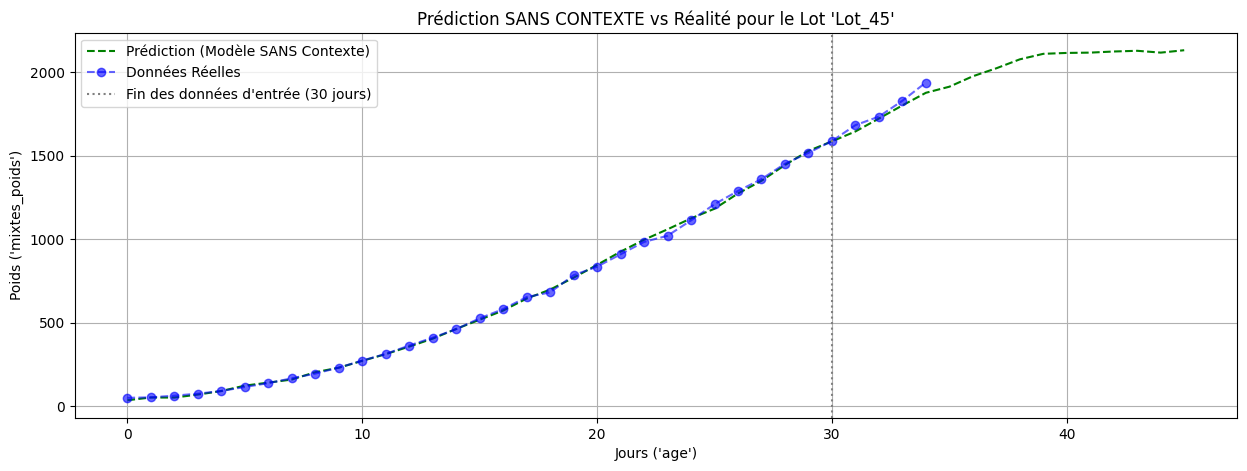

MAE sur l'horizon : 28.20 g | MAPE sur l'horizon : 1.55%

--- Évaluation du Lot : Lot_21 ---


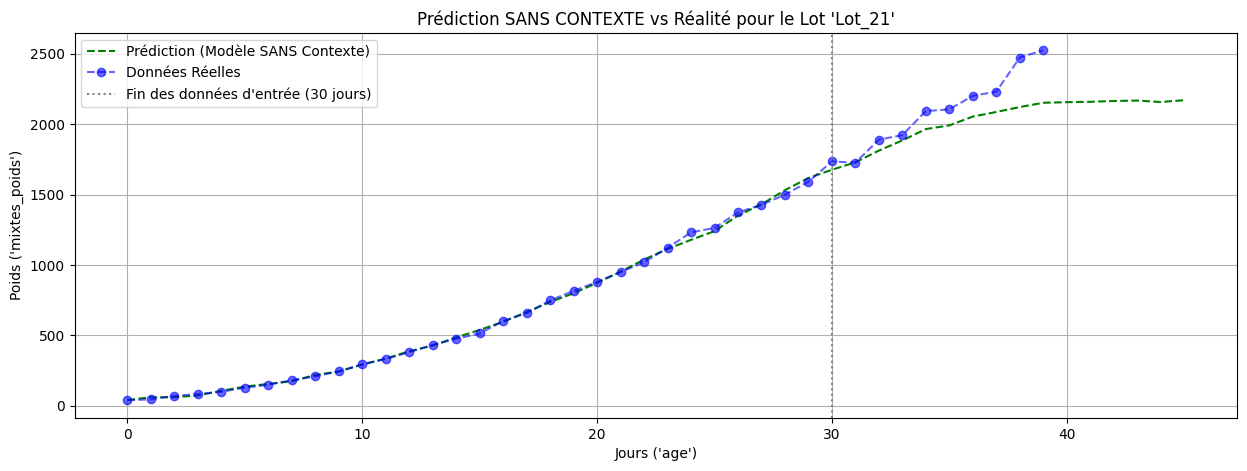

MAE sur l'horizon : 143.59 g | MAPE sur l'horizon : 6.33%

--- Évaluation du Lot : Lot_5 ---


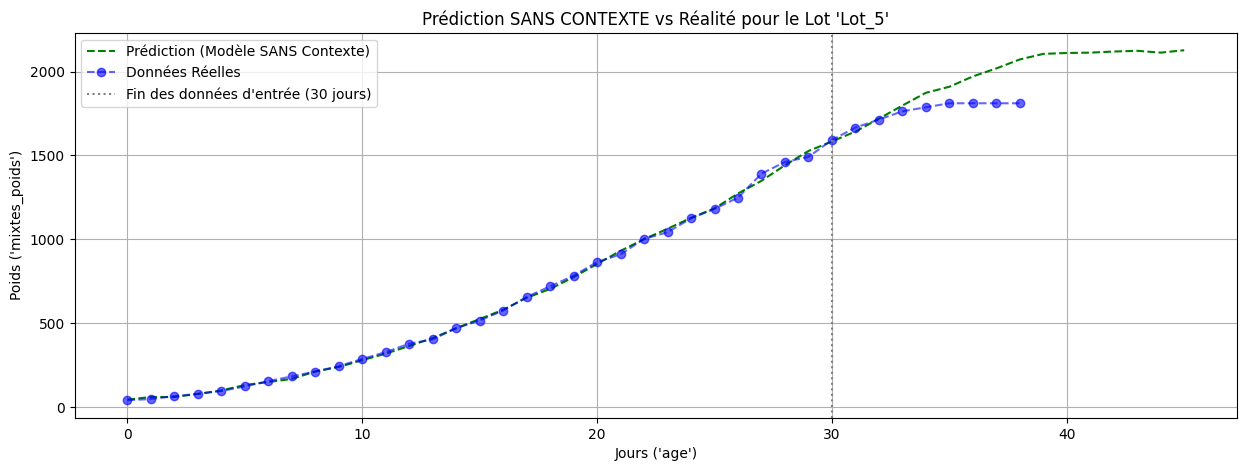

MAE sur l'horizon : 98.41 g | MAPE sur l'horizon : 5.47%

--- Évaluation du Lot : Lot_4 ---


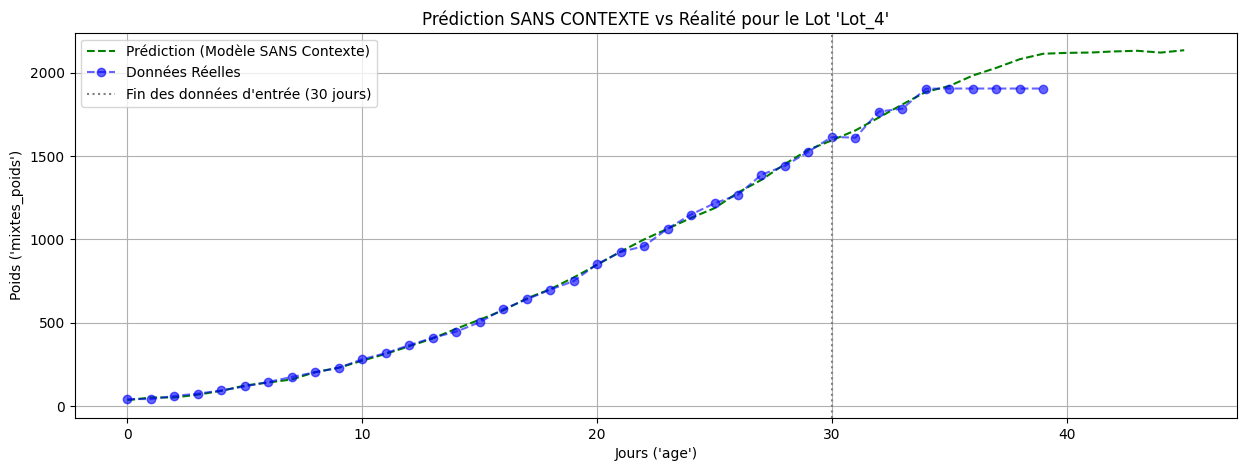

MAE sur l'horizon : 74.76 g | MAPE sur l'horizon : 4.01%

--- Évaluation du Lot : Lot_40 ---


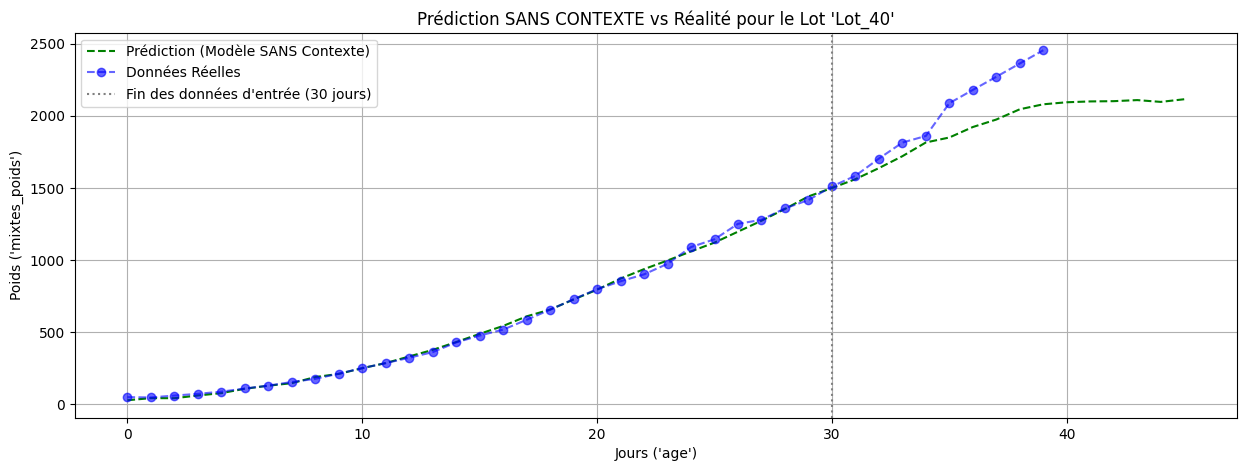

MAE sur l'horizon : 172.24 g | MAPE sur l'horizon : 7.86%


--- RAPPORT D'ÉVALUATION FINAL (MODE SANS CONTEXTE) ---
Nombre de lots de test évalués : 5
MAE Moyenne  : 103.44 g
MAPE Moyenne : 5.04 %

Les prédictions du modèle SANS contexte ont été sauvegardées dans : C:\Users\benam\Downloads\Ancien Download\inr_normallisé\predictions_sans_contexte.pkl


In [17]:
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import torch.nn.functional as F
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae

# ===================================================================
# CELLULE D'ÉVALUATION (POUR MODÈLE SANS CONTEXTE) — version MAPE
# ===================================================================

print("--- Préparation des données pour le set de TEST (sans contexte) ---")

matrice_poids_bruts_test = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=test_lot_ids,
    longueur_fixe=config_sans_contexte['data']['total_days']
)

donnees_normalisees_test = (matrice_poids_bruts_test - mean_train) / std_train

test_dataset_simple = PouletSansContexteDataset(
    lot_ids=test_lot_ids,
    matrice_poids=donnees_normalisees_test,
    config=config_sans_contexte
)
print(f"\nDataset de test (sans contexte) créé avec {len(test_dataset_simple)} échantillons.")

MODEL_PATH = r'C:\Users\benam\Downloads\Ancien Download\inr_normallisé\mon_modele_poulets_exp_sans-context_non-normalisé_clean.pt'
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Fichier modèle {MODEL_PATH} non trouvé.")

checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
config = checkpoint['config']
model_state_dict = checkpoint['inr_state_dict']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

inr = ModulatedFourierFeatures(input_dim=1, output_dim=1, **config['inr']).to(device)
inr.load_state_dict(model_state_dict)
inr.eval()
print("Modèle SANS CONTEXTE chargé avec succès.\n")

# --- 3. BOUCLE D'ÉVALUATION ---
all_mae_scores = []
all_mape_scores = []  # <-- remplace SMAPE
look_back_points = config['data']['look_back_window']
longueur_sequence = config['data']['total_days']
predictions_sans_contexte = {}

for i in range(len(test_dataset_simple)):
    batch_pour_inference = test_dataset_simple[i]
    id_lot_a_tester = test_dataset_simple.lot_ids[i]
    print(f"--- Évaluation du Lot : {id_lot_a_tester} ---")
    
    for key, value in batch_pour_inference.items():
        batch_pour_inference[key] = value.unsqueeze(0).to(device)
    
    coords_p = batch_pour_inference['coords_passe']
    poids_p = batch_pour_inference['poids_passe']

    with torch.set_grad_enabled(True):
        inner_lr_tensor = torch.tensor([config['optim']['lr_code']], device=device)
        modulations = torch.zeros(1, config['inr']['latent_dim'], device=device).requires_grad_()
        
        for step in range(config['optim']['inner_steps'] + 5):
            poids_recon_p = inr.modulated_forward(coords_p, modulations)
            loss_inner = F.mse_loss(poids_recon_p, poids_p.unsqueeze(-1))
            grad = torch.autograd.grad(loss_inner, modulations, create_graph=False)[0]
            modulations = modulations - inner_lr_tensor * grad
            
    z_final = modulations.detach()

    with torch.no_grad():
        grid_t_full = torch.linspace(0, longueur_sequence - 1, longueur_sequence).unsqueeze(-1).unsqueeze(0).to(device)
        prediction_norm_full = inr.modulated_forward(grid_t_full, z_final).squeeze().cpu().numpy()

    df_brut_original = X_all[X_all['Lot_ID'] == id_lot_a_tester]
    prediction_poids = (prediction_norm_full * std_train) + mean_train
    predictions_sans_contexte[id_lot_a_tester] = prediction_poids
    jours_predits = np.arange(longueur_sequence)
    jour_fin_entree = look_back_points
    
    plt.figure(figsize=(15, 5))
    plt.plot(jours_predits, prediction_poids, label="Prédiction (Modèle SANS Contexte)", color='green', linestyle='--')
    plt.plot(df_brut_original['age'], df_brut_original['mixtes_poids'], 'o--', label="Données Réelles", color='blue', alpha=0.6)
    plt.axvline(x=jour_fin_entree, color='gray', linestyle=':', label=f'Fin des données d\'entrée ({jour_fin_entree} jours)')
    plt.title(f"Prédiction SANS CONTEXTE vs Réalité pour le Lot '{id_lot_a_tester}'")
    plt.xlabel("Jours ('age')"); plt.ylabel("Poids ('mixtes_poids')"); plt.legend(); plt.grid(True)
    plt.show()

    # --- Métriques (MAE + MAPE) ---
    df_pred = pd.DataFrame({'age': jours_predits, 'poids_predit': prediction_poids})
    df_reel_horizon = df_brut_original[df_brut_original['age'] >= jour_fin_entree]
    
    if not df_reel_horizon.empty:
        df_reel_horizon = df_reel_horizon.copy()
        df_reel_horizon['age'] = df_reel_horizon['age'].astype(int)
        df_pred['age'] = df_pred['age'].round().astype(int)
        df_compare = pd.merge_asof(df_reel_horizon.sort_values('age'), df_pred.sort_values('age'), on='age')
        df_compare.dropna(inplace=True)
        
        if not df_compare.empty:
            y_true = df_compare['mixtes_poids'].values
            y_pred = df_compare['poids_predit'].values
            
            mae_error = mae(y_true, y_pred)
            all_mae_scores.append(mae_error)
            
            # MAPE (%), robuste aux zéros
            eps = 1e-8
            denom = np.maximum(np.abs(y_true), eps)
            mape_error = np.mean(np.abs(y_pred - y_true) / denom) * 100.0
            all_mape_scores.append(mape_error)
            
            print(f"MAE sur l'horizon : {mae_error:.2f} g | MAPE sur l'horizon : {mape_error:.2f}%\n")

# --- Rapport Final ---
if all_mae_scores:
    print("\n--- RAPPORT D'ÉVALUATION FINAL (MODE SANS CONTEXTE) ---")
    print(f"Nombre de lots de test évalués : {len(all_mae_scores)}")
    print(f"MAE Moyenne  : {np.mean(all_mae_scores):.2f} g")
    print(f"MAPE Moyenne : {np.mean(all_mape_scores):.2f} %")

# Sauvegarde des prédictions
DOSSIER_SAUVEGARDE = r'C:\Users\benam\Downloads\Ancien Download\inr_normallisé'
NOM_FICHIER = 'predictions_sans_contexte.pkl'
PATH_SAUVEGARDE_SC = os.path.join(DOSSIER_SAUVEGARDE, NOM_FICHIER)

with open(PATH_SAUVEGARDE_SC, 'wb') as f:
    pickle.dump(predictions_sans_contexte, f)

print(f"\nLes prédictions du modèle SANS contexte ont été sauvegardées dans : {PATH_SAUVEGARDE_SC}")
